In [120]:
import warnings

import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import os
import seaborn as sns

from aesara import tensor as at
from matplotlib.patches import Ellipse, transforms
from scipy import stats

In [2]:
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=(FutureWarning, UserWarning))
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89
az.rcParams["stats.ic_scale"] = "deviance"
az.rcParams["stats.information_criterion"] = "waic"

In [3]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

## Exercise 14E1

Add to the following model varying slopes on the predictor $x$.

$$
\begin{align}
y_i& \sim Normal(\mu_i,\sigma)\\
\mu_i& \sim \alpha_{group[i]} + \beta x_i\\
\alpha_{group}& \sim Normal(\alpha, \sigma_\alpha)\\
\alpha
\end{align}
$$

## Exercise 14M1

Repeat the café robot simulation from the beginning of the chapter. This time, set $\texttt{rho}$ to zero, so that there is no correlation between intercepts and slopes. How does the posterior distribution of the correlation reflect this change in the underlying simulation?

------

Simulate again a population of cafes, this time with no correlation

In [4]:
a = 3.5  # average morning wait time
b = -1.0  # average difference afternoon wait time
sigma_a = 1.0  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = 0  # correlation between intercepts and slopes

In [5]:
Mu = [a, b]

Remember how you can build the Sigma matrix in different ways

In [6]:
cov_ab = sigma_a * sigma_b * rho
Sigma = np.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]])
Sigma

array([[1.  , 0.  ],
       [0.  , 0.25]])

In [7]:
sigmas = [sigma_a, sigma_b]
Rho = np.matrix([[1, rho], [rho, 1]])

Sigma = np.diag(sigmas) * Rho * np.diag(sigmas)
Sigma

matrix([[1.  , 0.  ],
        [0.  , 0.25]])

In [8]:
N_cafes = 20

In [9]:
vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_cafes)

In [10]:
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

In [27]:
def Gauss2d(mu, cov, ci, ax=None):
    """Copied from statsmodel"""
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    v_, w = np.linalg.eigh(cov) #eigenvalues and eigenvectors
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees

    for level in ci:
        v = 2 * np.sqrt(v_ * stats.chi2.ppf(level, 2))  # get size corresponding to level
        ell = Ellipse( 
            mu[:2],
            v[0],
            v[1],
            angle = 180 + angle,
            facecolor="None",
            edgecolor="k",
            alpha=max(1 - level,.1),
            lw=1.5,
        )
        ell.set_clip_box(ax.bbox)
        #ell.set_alpha(0.5)
        ax.add_artist(ell)

    return ax

plotting intercepts and slopes. The relationship higlights how cafes with long waiting times (large a's) usually have a lot of improvement in the afternoon (a shorter waiting time). Correlation in the a and b parameters is lost now. That is easy to see by the shape of the gaussian underlying the points in the plot: it has no rotation and change in the proportion of the axis.

/scratch/28266451/ipykernel_1250197/2330047673.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(u[1] / u[0])


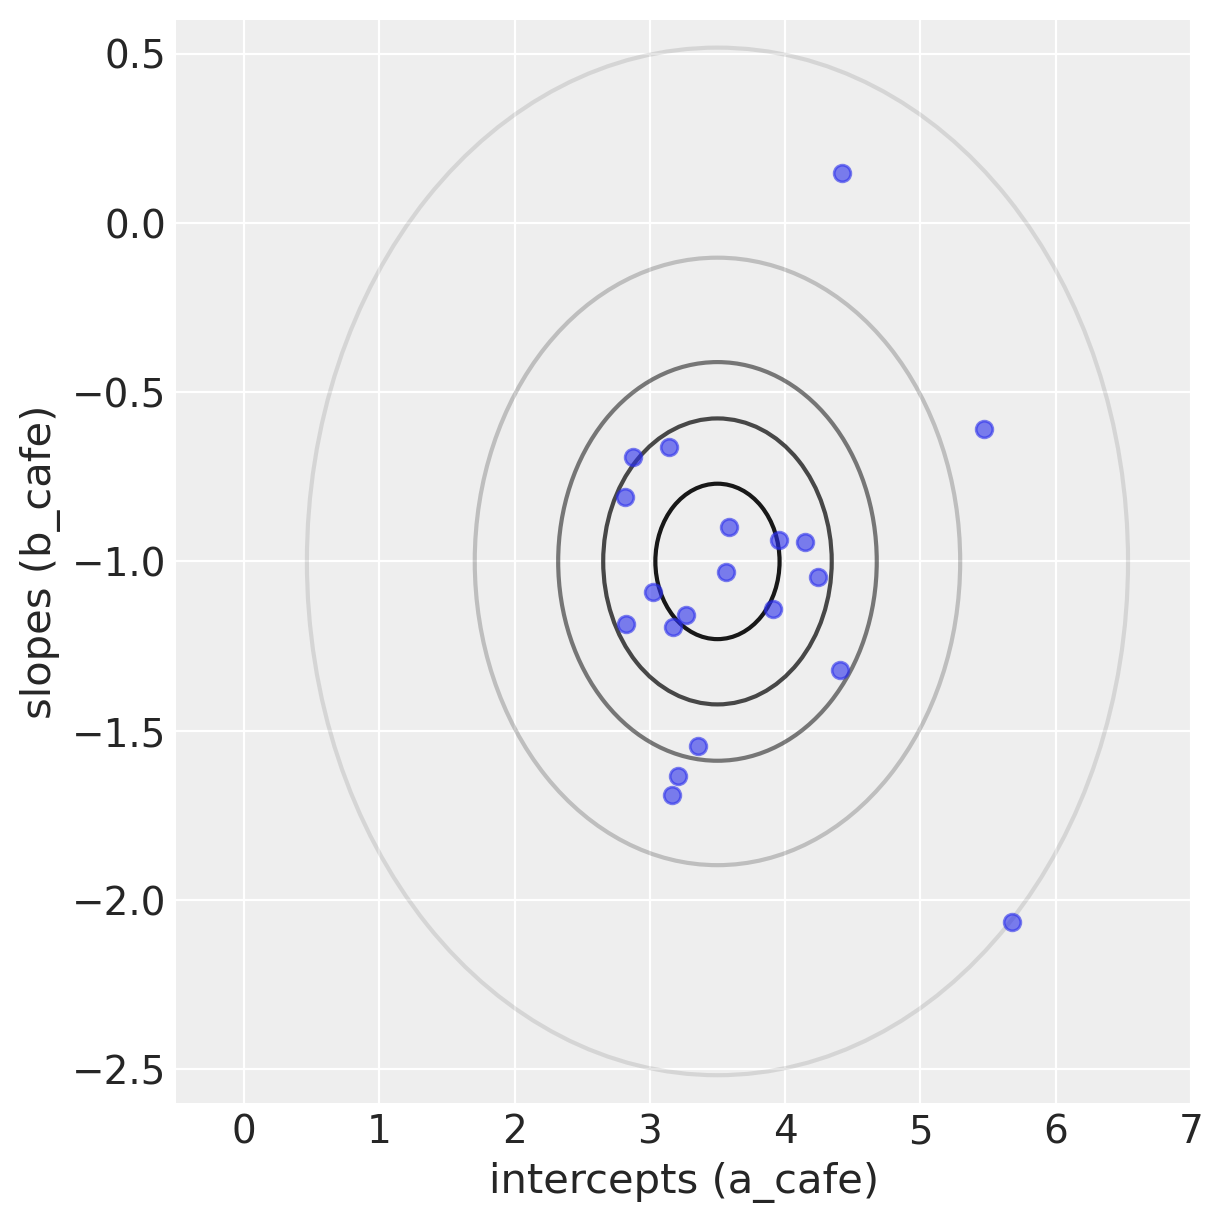

In [12]:
ax = Gauss2d(Mu, np.asarray(Sigma), [0.1, 0.3, 0.5, 0.8, 0.99])
ax.scatter(a_cafe, b_cafe, alpha=0.6)
ax.set_xlim(-0.5, 7)
ax.set_ylim(-2.6, 0.6)
ax.set_xlabel("intercepts (a_cafe)")
ax.set_ylabel("slopes (b_cafe)");

Above were simulations of cafes and the full description of their properties (through simulated intercepts and slopes). Below we simulate visits to cafes.

In [13]:
N_visits = 10
afternoon = np.tile([0, 1], N_visits * N_cafes // 2)  # wrap with int() to suppress warnings
cafe_id = np.repeat(np.arange(0, N_cafes), N_visits)  # 1-20 (minus 1 for python indexing)

mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
sigma = 0.5  # std dev within cafes

wait = np.random.normal(loc=mu, scale=sigma, size=N_visits * N_cafes)
d = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))
d

cafe  afternoon      wait
0       0          0  2.824015
1       0          1  1.804069
2       0          0  2.893324
3       0          1  0.935652
4       0          0  4.149596
..    ...        ...       ...
195    19          1  1.868736
196    19          0  3.666390
197    19          1  1.158664
198    19          0  3.352406
199    19          1  1.512274

[200 rows x 3 columns]

Building the model

In [14]:
cafe_idx = d["cafe"].values
with pm.Model() as m14m1:
    # LKJCholeskyCov is more efficient than LKJCorr
    # PyMC >= 3.9 extracts the stds and matrix of correlations automatically for us
    # the distribution of standard deviations is included as an option because the
    # functions also calculates correlation within cafes to output the matrix
    chol, Rho_, sigma_cafe = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )

    a = pm.Normal("a", 5.0, 2.0)  # prior for average intercept
    b = pm.Normal("b", -1.0, 0.5)  # prior for average slope
    ab_cafe = pm.MvNormal(
        "ab_cafe", mu=at.stack([a, b]), chol=chol, shape=(N_cafes, 2)
    )  # population of varying effects
    # shape needs to be (N_cafes, 2) because we're getting back both a and b for each cafe

    mu = ab_cafe[cafe_idx, 0] + ab_cafe[cafe_idx, 1] * d["afternoon"].values  # linear model
    sigma_within = pm.Exponential("sigma_within", 1.0)  # prior stddev within cafes

    wait = pm.Normal("wait", mu=mu, sigma=sigma_within, observed=d["wait"].values)  # likelihood
    if(not os.path.exists('trace_14m1.nc')):
        trace_14m1 = pm.sample(4000, tune=4000, target_accept=0.9)
        trace_14m1.rename({"chol_cov_corr": "Rho", "chol_cov_stds": "sigma_cafe"}, inplace=True)
        az.InferenceData.to_netcdf(trace_14m1, 'trace_14m1.nc')
        


In [15]:
#az.InferenceData.to_netcdf(trace_14_1, 'trace_14_1.nc')
trace_14m1 = az.from_netcdf('trace_14m1.nc')

post = trace_14m1.posterior

The table of posteriors gives a correlation closer to zero, which is skewed towards positive values. This is proably due to the distribution of the prior correlation matrix of intercepts and slopes. A higher $eta$ parameter could help narrowing the prior distribution.

In [17]:
az.summary(trace_14m1, var_names=["a", "b", "sigma_within", "Rho", "sigma_cafe"], round_to=2)

/faststorage/project/sandbox_scrna_course/Repo/bayesian_statistics/statistical_rethinking_2/pymc4/pymc4_env2/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a              3.72  0.18      3.43       4.01        0.0      0.0  19410.95   
b             -1.08  0.13     -1.29      -0.88        0.0      0.0  15477.91   
sigma_within   0.55  0.03      0.50       0.60        0.0      0.0  17598.61   
Rho[0, 0]      1.00  0.00      1.00       1.00        0.0      0.0  16000.00   
Rho[0, 1]      0.16  0.26     -0.23       0.61        0.0      0.0   9679.39   
Rho[1, 0]      0.16  0.26     -0.23       0.61        0.0      0.0   9679.39   
Rho[1, 1]      1.00  0.00      1.00       1.00        0.0      0.0  15725.60   
sigma_cafe[0]  0.77  0.14      0.55       0.98        0.0      0.0  17796.39   
sigma_cafe[1]  0.46  0.13      0.26       0.66        0.0      0.0   5181.51   

               ess_tail  r_hat  
a              12603.63    1.0  
b              13254.33    1.0  
sigma_within   12506.80    1.0  
Rho[0, 0]      16000.00    NaN  
Rho[0, 1]       9691.82    1.0  
Rho[1, 0]       9691.82    1.0  
Rho[1, 1]      15581.43    1.0  
sigma_cafe[0]  12746.37    1.0  
sigma_cafe[1]   5167.68    1.0

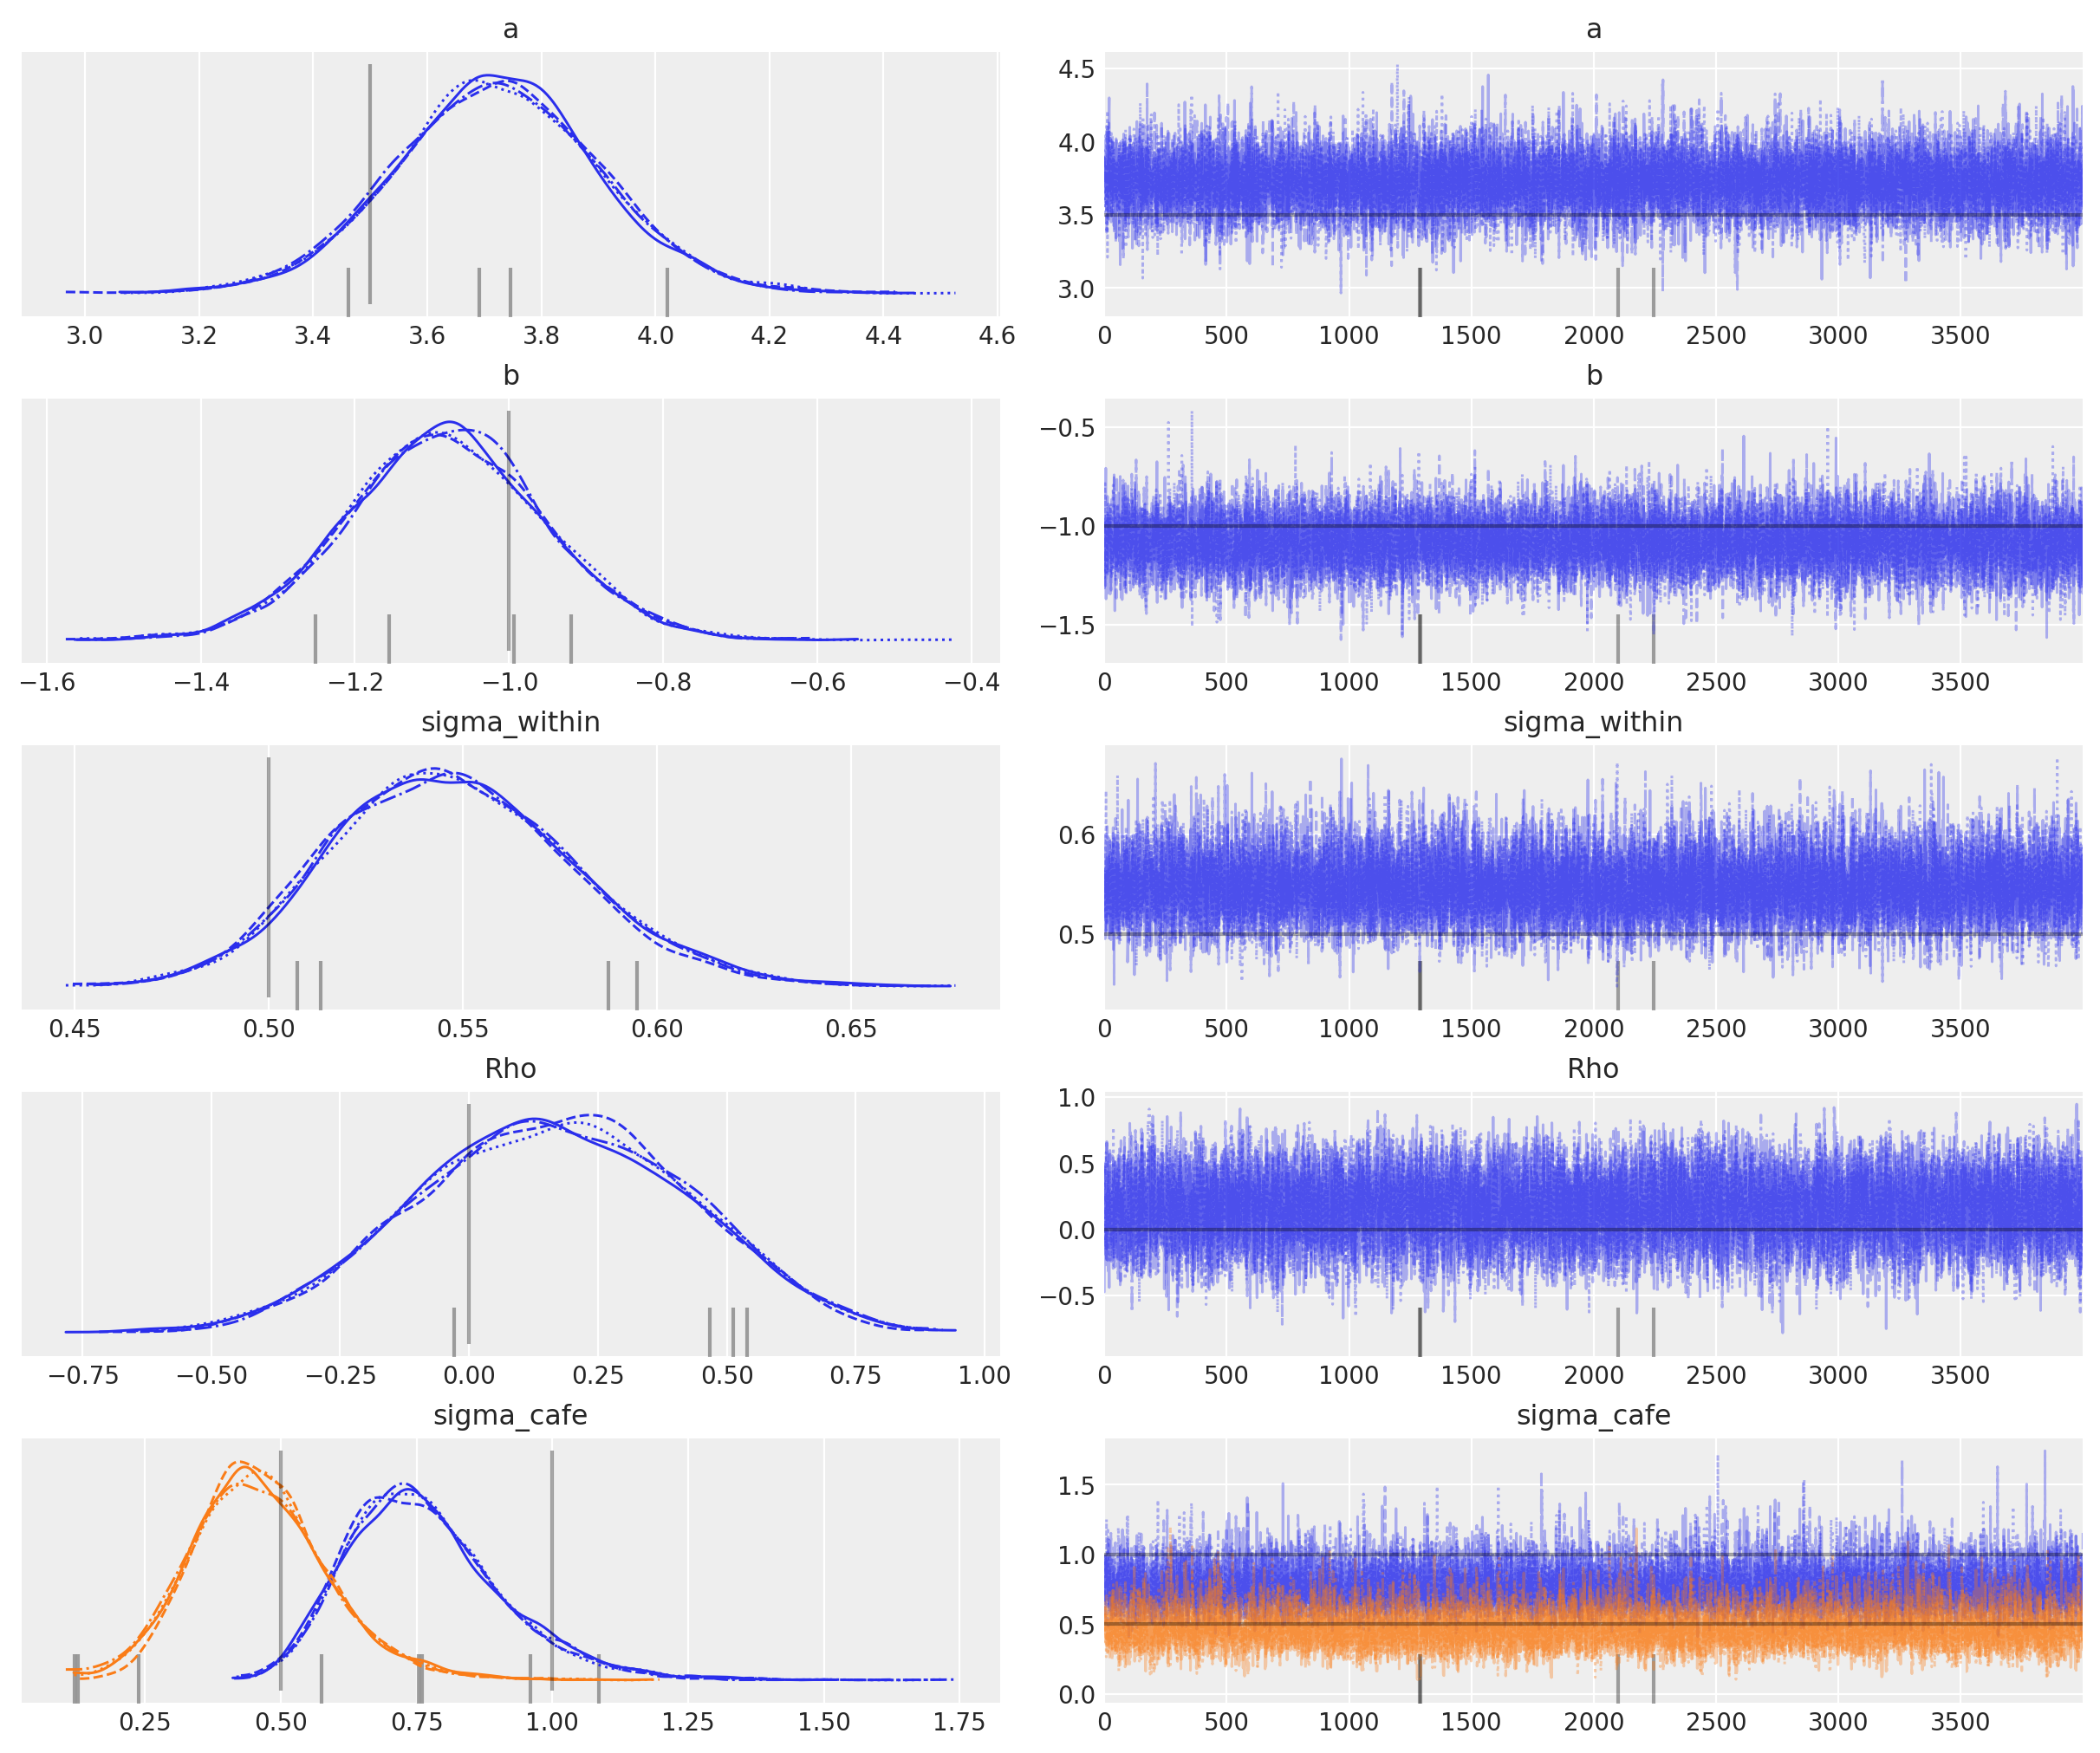

In [18]:
az.plot_trace(
    trace_14m1,
    compact=True,
    var_names=["~ab_cafe", "~chol_cov"],
    coords={"chol_cov_corr_dim_0": 1, #Takes second element of first row in correlation matrix
            "chol_cov_corr_dim_1": 0}, #Takes first element of second row in correlation matrix
    lines=[
        ("a", {}, Mu[0]),
        ("b", {}, Mu[1]),
        ("sigma_cafe", {}, sigmas),
        ("Rho", {}, Rho[0, 1]),
        ("sigma_within", {}, sigma),
    ],
);

Prior and posterior for the correlation coefficient, inferred only from the waiting times resulting from the model of cafe's!!!

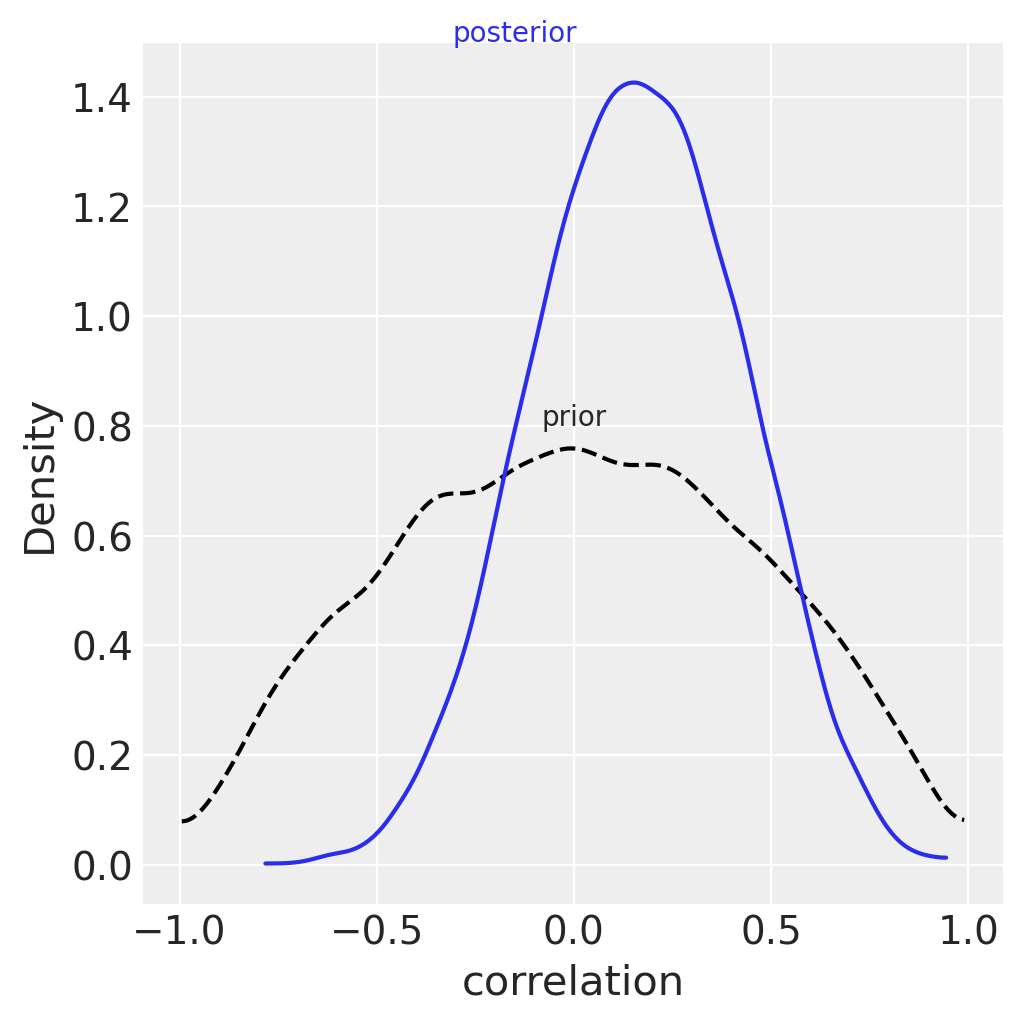

In [18]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))

R = pm.LKJCorr.dist(n=2, eta=2, size=10000).eval()
az.plot_kde(R, plot_kwargs={"color": "k", "linestyle": "--"})
ax.text(0, 0.8, "prior", horizontalalignment="center")

az.plot_kde(
    np.array(
        az.extract_dataset(post["Rho"].sel(chol_cov_corr_dim_0=1, chol_cov_corr_dim_1=0)).to_array()
    ),
    ax=ax,
    plot_kwargs={"color": "C0"},
)
ax.text(-0.15, 1.5, "posterior", color="C0", horizontalalignment="center")

ax.set_xlabel("correlation")
ax.set_ylabel("Density");

We can observe the strong pooling effect on the unpooled values. Note how the underlying gaussian distribution is now rotated to reflect the presence of an estimated positive correlation.

In [21]:
# compute unpooled estimates directly from data
a1b1 = d.groupby(["afternoon", "cafe"]).agg("mean").unstack(level=0).values
a1 = a1b1[:, 0]
b1 = a1b1[:, 1] - a1 # in the afternoon data generated you have the sum of a and b, so you need only b

# extract posterior means of partially pooled estimates
a2b2 = post["ab_cafe"].mean(dim=("chain", "draw"))
a2 = a2b2[:, 0]
b2 = a2b2[:, 1]

# compute posterior mean bivariate Gaussian
ab = post[["a", "b"]].mean(dim=("chain", "draw"))
Mu_est = np.array([ab["a"], ab["b"]])
chol_model = pm.expand_packed_triangular(
    2, post["chol_cov"].mean(dim=("chain", "draw")).to_numpy(), lower=True
).eval()
Sigma_est = np.dot(chol_model, chol_model.T)

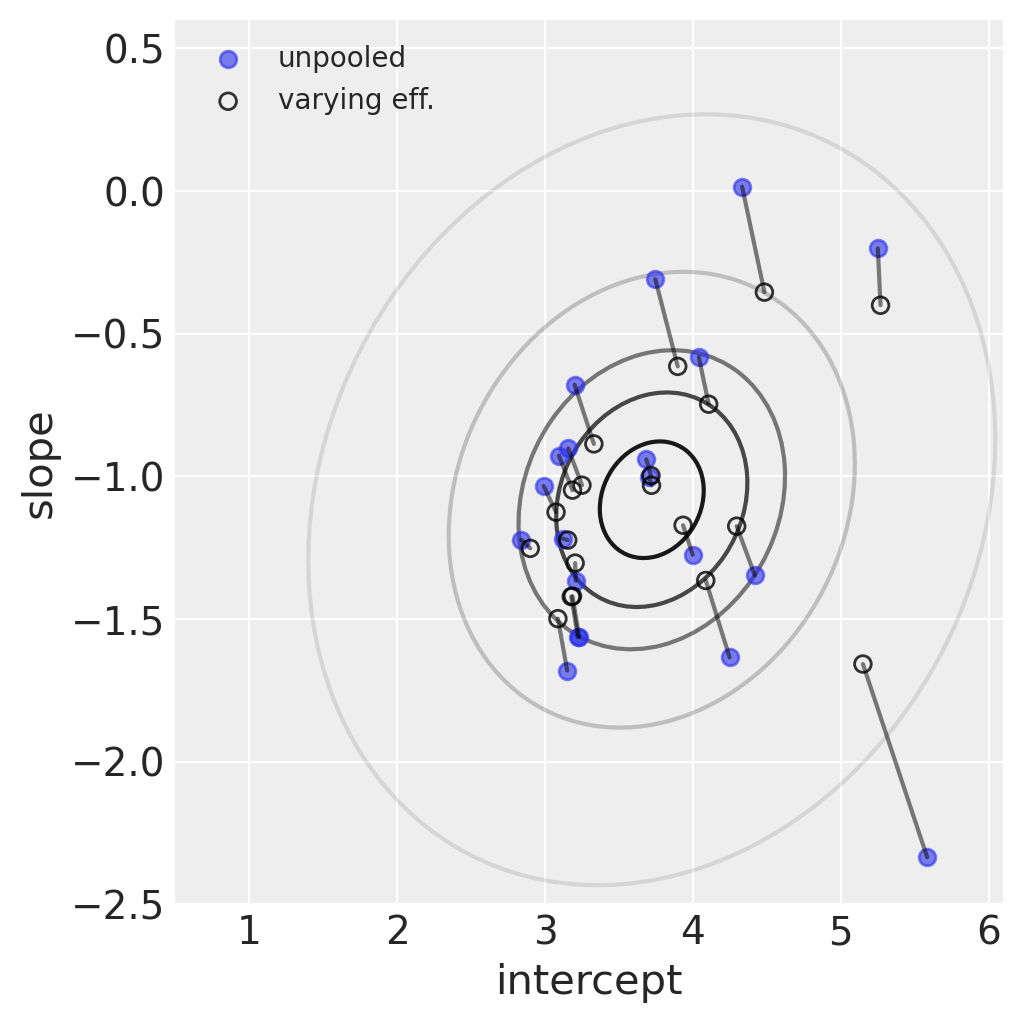

In [22]:
# draw contours
_, ax = plt.subplots(1, 1, figsize=(5, 5))
_ = Gauss2d(mu=Mu_est, cov=np.asarray(Sigma_est), ci=[0.1, 0.3, 0.5, 0.8, 0.99], ax=ax)

# plot both and connect with lines
ax.scatter(a1, b1, label="unpooled", alpha=0.6)
ax.scatter(a2, b2, label="varying eff.", facecolors="none", edgecolors="k", lw=1, alpha=0.8)

ax.plot([a1, a2], [b1, b2], "k-", alpha=0.5)
ax.set_xlabel("intercept")
ax.set_ylabel("slope")
ax.set_xlim(0.5, 6.1)
ax.set_ylim(-2.5, 0.6)
plt.legend(fontsize=10);

Similarly if we transform into waiting times. Note that the low correlation does make for quite higher afternoon waiting times when afternoon times are also high. That is expected in comparison to a negative correlation of intercepts and slopes

In [23]:
# convert varying effects to waiting times
wait_morning_1 = a1
wait_afternoon_1 = a1 + b1
wait_morning_2 = a2
wait_afternoon_2 = a2 + b2

# now shrinkage distribution by simulation
v = np.random.multivariate_normal(mean=Mu_est, cov=Sigma_est, size=1000)
v[:, 1] = v[:, 0] + v[:, 1]  # calculate afternoon wait
Sigma_est2 = np.cov(v.T)
Mu_est2 = Mu_est.copy()
Mu_est2[1] = Mu_est[0] + Mu_est[1]

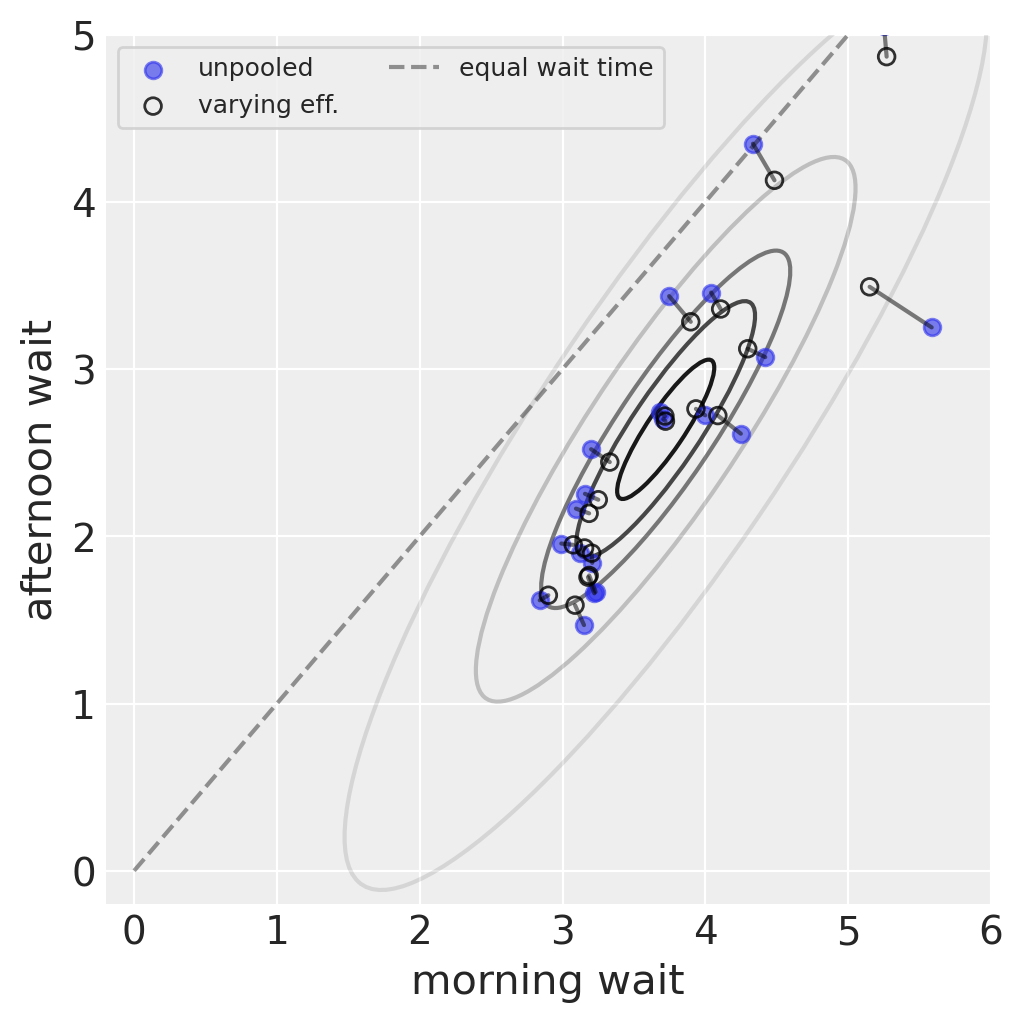

In [24]:
# draw contours
_, ax = plt.subplots(1, 1, figsize=(5, 5))
_ = Gauss2d(mu=Mu_est2, cov=np.asarray(Sigma_est2), ci=[0.1, 0.3, 0.5, 0.8, 0.99], ax=ax)

# plot both and connect with lines
ax.scatter(wait_morning_1, wait_afternoon_1, label="unpooled", alpha=0.6)
ax.scatter(
    wait_morning_2,
    wait_afternoon_2,
    label="varying eff.",
    facecolors="none",
    edgecolors="k",
    lw=1,
    alpha=0.8,
)

ax.plot(
    [wait_morning_1, wait_morning_2],
    [wait_afternoon_1, wait_afternoon_2],
    "k-",
    alpha=0.5,
)
ax.plot(range(6), range(6), "k--", label="equal wait time", alpha=0.4)
ax.set_xlabel("morning wait")
ax.set_ylabel("afternoon wait")
ax.set_xlim(-0.2, 6)
ax.set_ylim(-0.2, 5)
plt.legend(fontsize=9, ncol=2, loc="upper left", frameon=True);

## Exercise 14M2

Fit the cafes data with a model having independent gaussians for intercepts and slopes. Use WAIC to compare this model to the one from the chapter using a multivariate gaussian prior.

In [25]:
a = 3.5  # average morning wait time
b = -1.0  # average difference afternoon wait time
sigma_a = 1.0  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes

Mu = [a, b]

cov_ab = sigma_a * sigma_b * rho
Sigma = np.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]])
Sigma

array([[ 1.  , -0.35],
       [-0.35,  0.25]])

In [26]:
N_cafes = 20

vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_cafes)

a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

In [27]:
N_visits = 10
afternoon = np.tile([0, 1], N_visits * N_cafes // 2)  # wrap with int() to suppress warnings
cafe_id = np.repeat(np.arange(0, N_cafes), N_visits)  # 1-20 (minus 1 for python indexing)

mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
sigma = 0.5  # std dev within cafes

wait = np.random.normal(loc=mu, scale=sigma, size=N_visits * N_cafes)
d = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))
d

cafe  afternoon      wait
0       0          0  4.175268
1       0          1  2.669558
2       0          0  4.634613
3       0          1  2.765046
4       0          0  3.476687
..    ...        ...       ...
195    19          1  1.257677
196    19          0  3.680629
197    19          1  1.567150
198    19          0  3.299703
199    19          1  0.805505

[200 rows x 3 columns]

In [34]:
cafe_idx = d["cafe"].values
with pm.Model() as m14m2:
   
    a = pm.Normal("a", 5.0, 2.0)  # prior for average intercept
    b = pm.Normal("b", -1.0, 0.5)  # prior for average slope
    sigma_a = pm.Exponential("sigma_a", 1) #prior for intercept sd
    sigma_b = pm.Exponential("sigma_b", 1) #prior for intercept sd

    a_cafe = pm.Normal("a_cafe", a, sigma_a, shape=N_cafes)
    b_cafe = pm.Normal("b_cafe", b, sigma_b, shape=N_cafes)
    
    mu = a_cafe[cafe_idx] + b_cafe[cafe_idx] * d["afternoon"].values  # linear model
    sigma = pm.Exponential("sigma", 1.0)  # prior stddev within cafes

    wait = pm.Normal("wait", mu=mu, sigma=sigma, observed=d["wait"].values)  # likelihood
    if(not os.path.exists('trace_14m2.nc')):
        trace_14m2 = pm.sample(4000, tune=4000, target_accept=0.9)
        az.InferenceData.to_netcdf(trace_14m2, 'trace_14m2.nc')
        


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma_a, sigma_b, a_cafe, b_cafe, sigma]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 40 seconds.


In [35]:
trace_14m2 = az.from_netcdf('trace_14m2.nc')
post_m2 = trace_14m2.posterior

Look at the results of the posterior samples

In [41]:
az.summary(trace_14m2, var_names=["a", "b", "sigma_a", "sigma_b", "sigma"], round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a        3.68  0.18      3.40       3.97        0.0      0.0  23034.62   
b       -1.15  0.15     -1.40      -0.91        0.0      0.0  20533.54   
sigma_a  0.76  0.14      0.55       0.97        0.0      0.0  19709.69   
sigma_b  0.63  0.14      0.42       0.83        0.0      0.0  13503.33   
sigma    0.52  0.03      0.47       0.56        0.0      0.0  17564.13   

         ess_tail  r_hat  
a        11282.27    1.0  
b        12902.53    1.0  
sigma_a  11733.90    1.0  
sigma_b  12378.74    1.0  
sigma    12549.60    1.0

In [57]:
for i in range(20):
    rho = np.corrcoef(post_m2['a_cafe'].mean(['chain'])[:,i],
                      post_m2['b_cafe'].mean(['chain'])[:,i])[0,1]
    print(f'Posterior correlation for cafe {i}: {rho}')

Posterior correlation for cafe 0: -0.669820373879427
Posterior correlation for cafe 1: -0.6637538060853194
Posterior correlation for cafe 2: -0.6385297097440326
Posterior correlation for cafe 3: -0.6573585488219068
Posterior correlation for cafe 4: -0.657651789819371
Posterior correlation for cafe 5: -0.6584966861070276
Posterior correlation for cafe 6: -0.6825202950899844
Posterior correlation for cafe 7: -0.6576337837214331
Posterior correlation for cafe 8: -0.6653850382752552
Posterior correlation for cafe 9: -0.6557814170656677
Posterior correlation for cafe 10: -0.6720646738140631
Posterior correlation for cafe 11: -0.6544448826190558
Posterior correlation for cafe 12: -0.6753047651233498
Posterior correlation for cafe 13: -0.6287634703358252
Posterior correlation for cafe 14: -0.6521078119544567
Posterior correlation for cafe 15: -0.6728780350951972
Posterior correlation for cafe 16: -0.6517381704816115
Posterior correlation for cafe 17: -0.6512877088857039
Posterior correlation 

Posterior correlations reflect the simulated data for each cafe! The trace looks also nice.

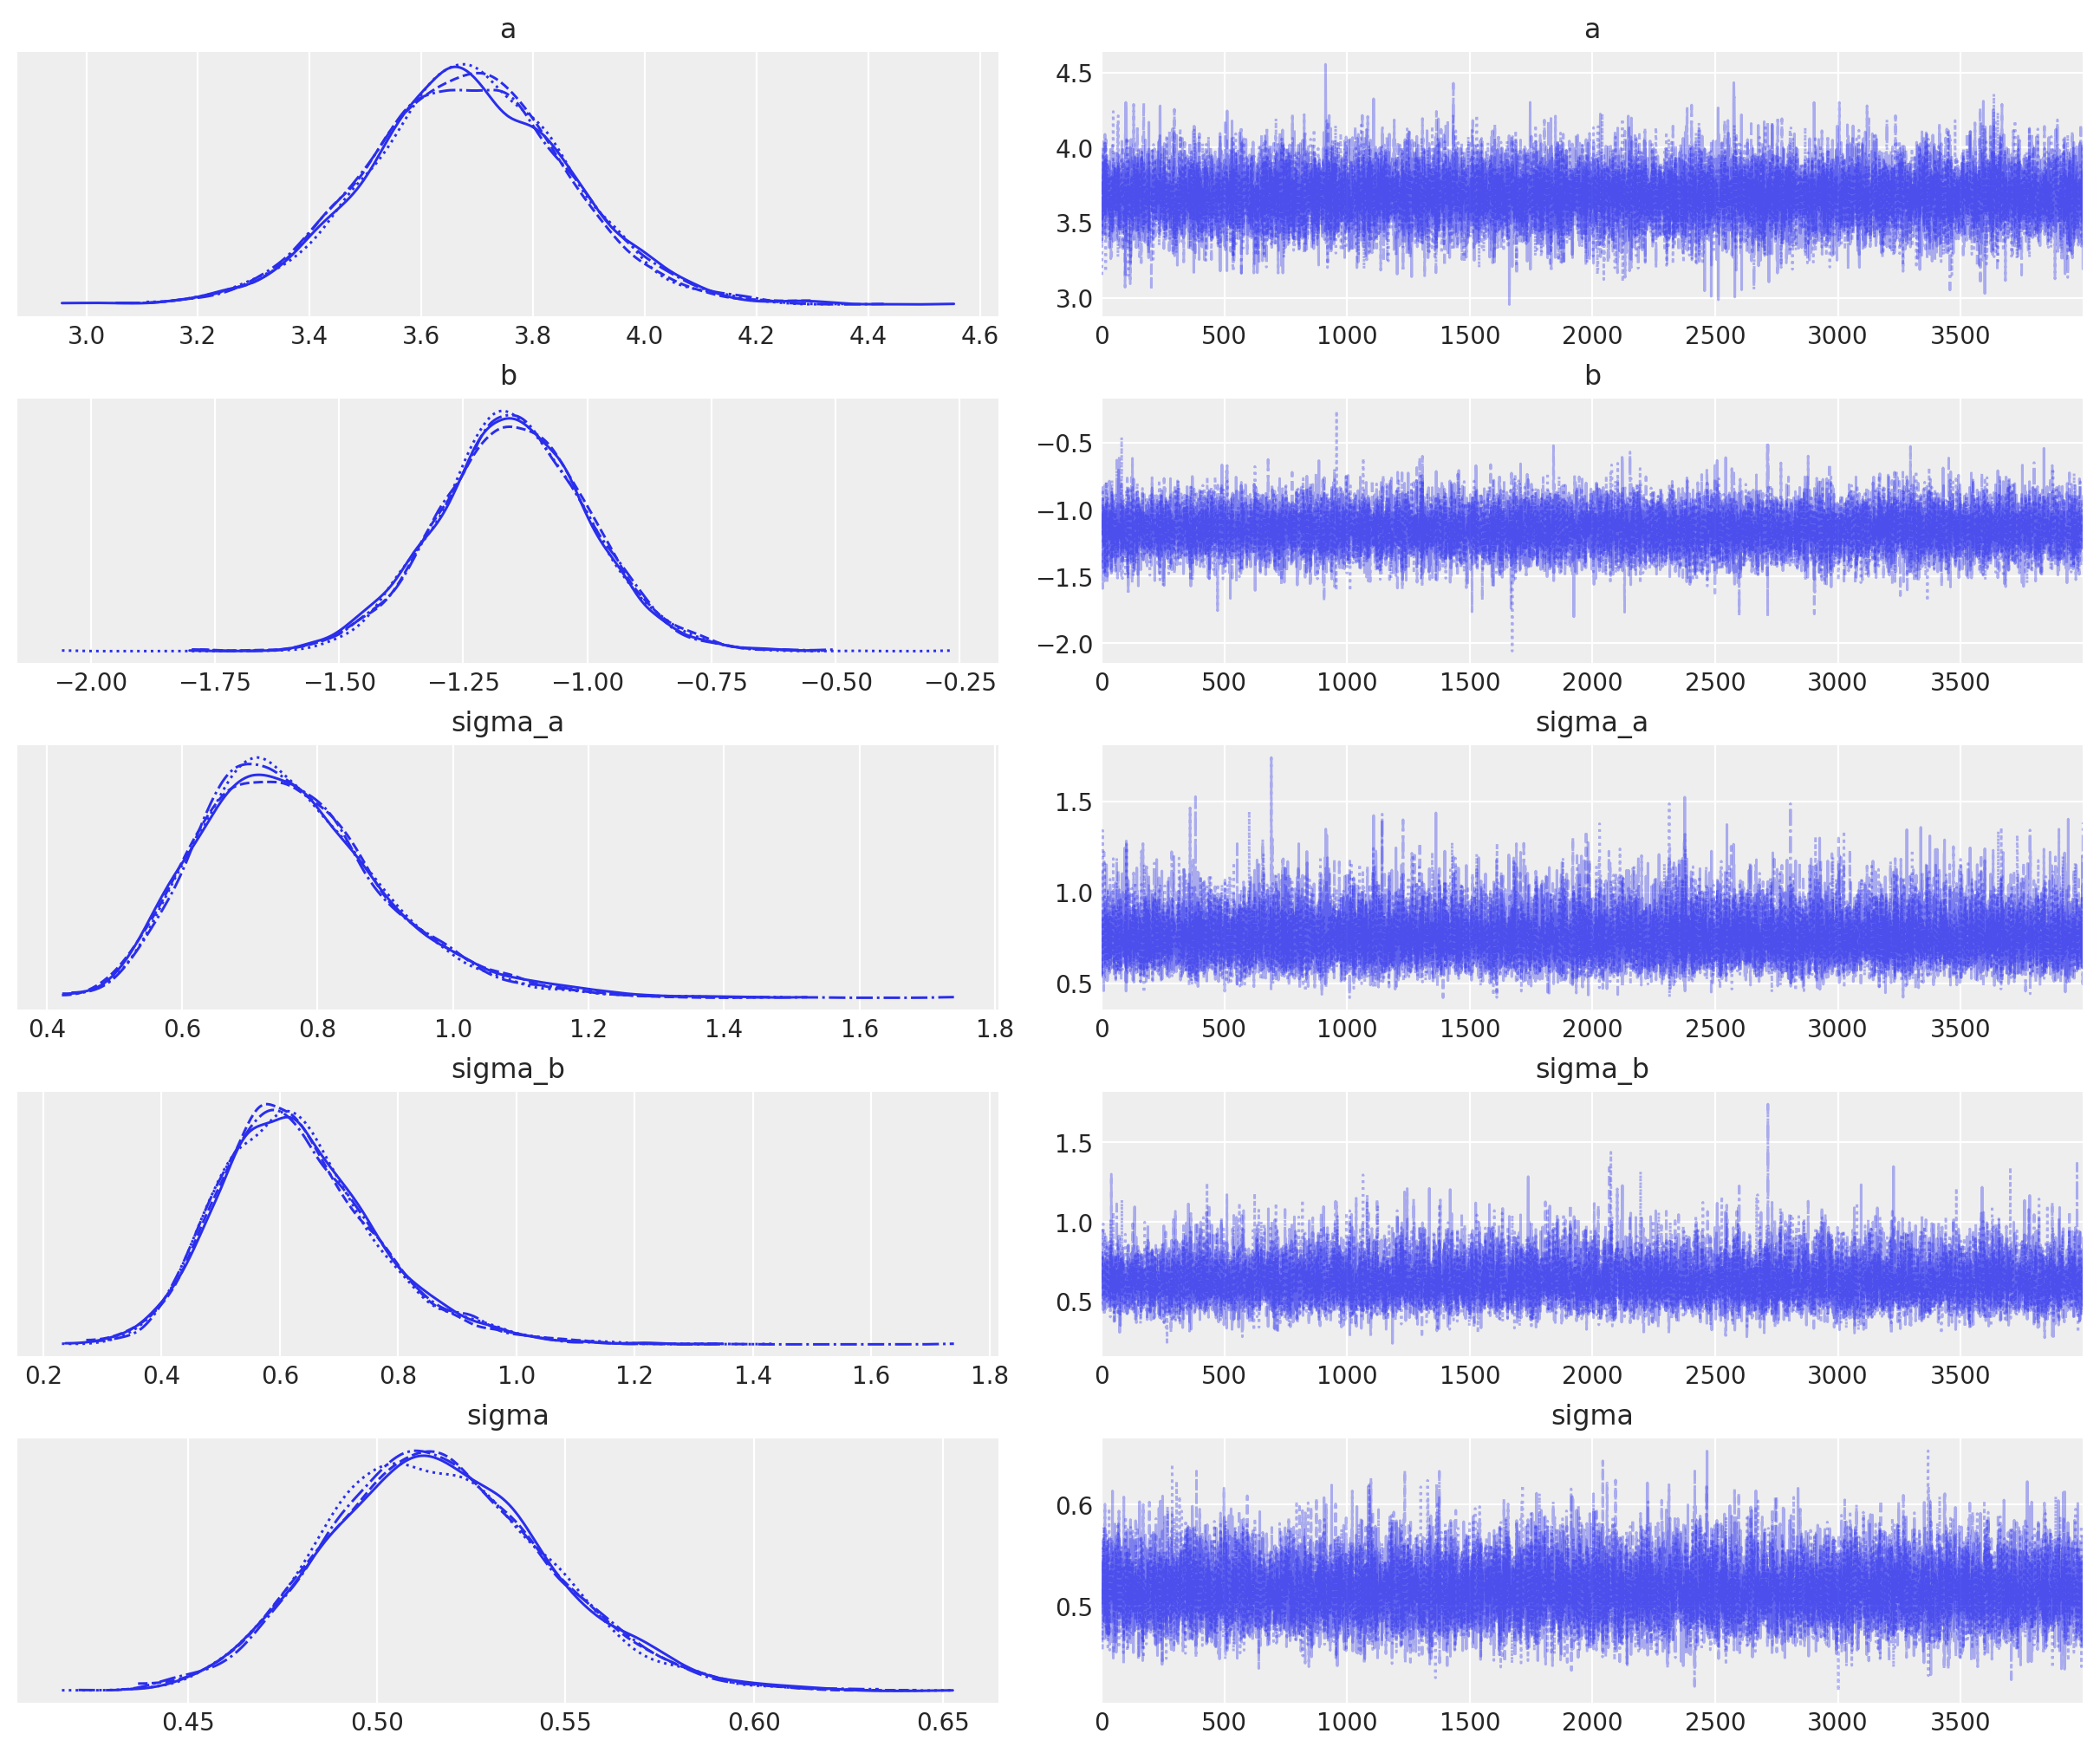

In [58]:
az.plot_trace(
    trace_14m2,
    compact=True,
    var_names=["a", "b", "sigma_a", "sigma_b", "sigma"],
    lines=[
        #("a", {}, a),
        #("b", {}, b),
        #("Rho", {}, Rho[0, 1]),
        #("sigma", {}, sigma),
    ],
);

However, note below that we have not gotten the same result as when pooling slopes and intercepts through the multivariate gaussian. There is no correlation structure in the posterior values of our model, meaning that we fit independently the two variables of our model.

In [21]:
# compute unpooled estimates directly from data
a1b1 = d.groupby(["afternoon", "cafe"]).agg("mean").unstack(level=0).values
a1 = a1b1[:, 0]
b1 = a1b1[:, 1] - a1 # in the afternoon data generated you have the sum of a and b, so you need only b

# extract posterior means of partially pooled estimates
a2 = post_m2["a_cafe"].mean(dim=("chain", "draw"))
b2 = post_m2["b_cafe"].mean(dim=("chain", "draw"))

# compute posterior mean
ab = post_m2[["a", "b"]].mean(dim=("chain", "draw"))
Mu_est = np.array([ab["a"], ab["b"]])

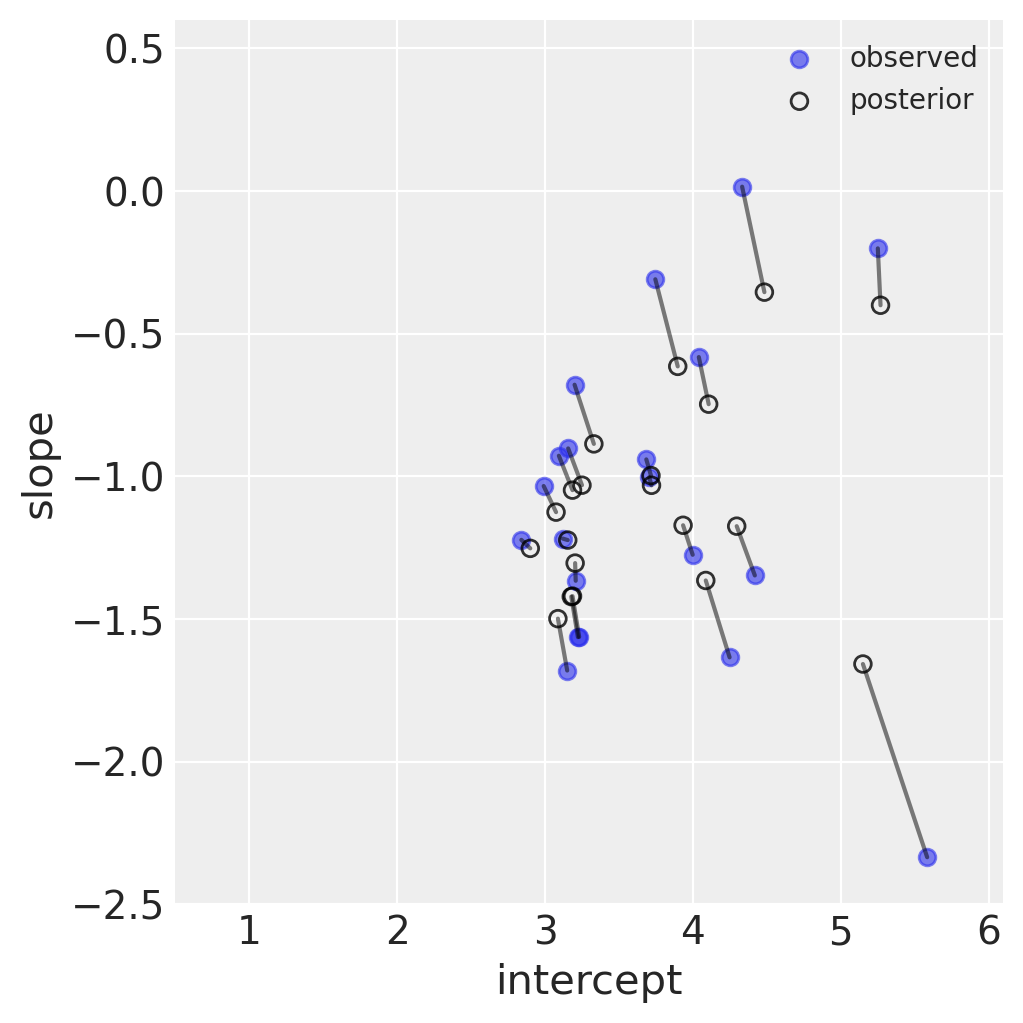

In [60]:
# draw contours
_, ax = plt.subplots(1, 1, figsize=(5, 5))
#_ = Gauss2d(mu=Mu_est, cov=np.asarray(Sigma_est), ci=[0.1, 0.3, 0.5, 0.8, 0.99], ax=ax)

# plot both and connect with lines
ax.scatter(a1, b1, label="observed", alpha=0.6)
ax.scatter(a2, b2, label="posterior", facecolors="none", edgecolors="k", lw=1, alpha=0.8)

ax.plot([a1, a2], [b1, b2], "k-", alpha=0.5)
ax.set_xlabel("intercept")
ax.set_ylabel("slope")
ax.set_xlim(0.5, 6.1)
ax.set_ylim(-2.5, 0.6)
plt.legend(fontsize=10);

Now we do a WAIC comparison. The model without pooling seems to do better and has only three more efective parameters in the model. Pareto k values are also not unusual from one model to another.

In [4]:
trace_14_1 = az.from_netcdf('trace_14_1.nc')

In [5]:
trace_14m2 = az.from_netcdf('trace_14m2.nc')

In [6]:
az.compare({"pooled": trace_14_1, "default": trace_14m2})

rank   elpd_waic     p_waic  elpd_diff    weight         se  \
default     0  339.296502  32.538584   0.000000  0.593296  19.984767   
pooled      1  359.855045  29.954853  20.558543  0.406704  20.008611   

               dse  warning     scale  
default   0.000000     True  deviance  
pooled   27.401876     True  deviance

(0.0, 0.6)

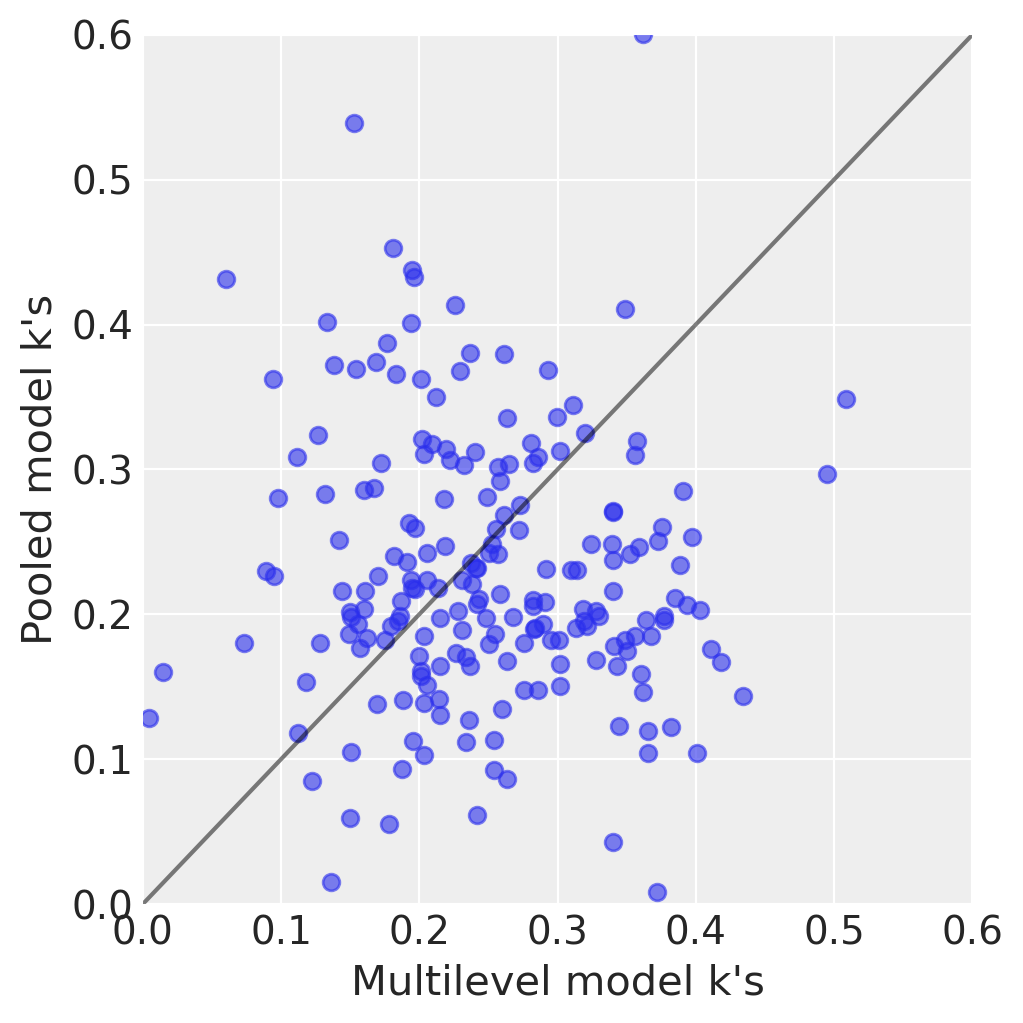

In [8]:
# store pareto-k values for plot:
kPooled = az.loo(trace_14_1, pointwise=True).pareto_k.values
kDefault = az.loo(trace_14m2, pointwise=True).pareto_k.values

_, ax = plt.subplots(1, 1, figsize=(5, 5))
#_ = Gauss2d(mu=Mu_est, cov=np.asarray(Sigma_est), ci=[0.1, 0.3, 0.5, 0.8, 0.99], ax=ax)

# plot both and connect with lines
ax.scatter(kDefault, kPooled, alpha=0.6)

ax.plot([0, .6], [0, .6], "k-", alpha=0.5)
ax.set_xlabel("Multilevel model k's")
ax.set_ylabel("Pooled model k's")
ax.set_xlim(0, 0.6)
ax.set_ylim(0, 0.6)
#plt.legend(fontsize=10);

## Exercise 14H1

Let’s revisit the Bangladesh fertility data from the practice problems for Chapter 13. Fit a model with both varying intercepts by `district_id` and varying slopes of urban by `district_id`. You are still predicting `use.contraception`. Inspect the correlation between the intercepts and slopes. Can you interpret this correlation, in terms of what it tells you about the pattern of contraceptive use in the sample? It might help to plot the mean (or median) varying effect estimates for both the intercepts and slopes, by district. Then you can visualize the correlation and maybe more easily think through what it means to have a particular correlation. Plotting predicted proportion of women using contraception, with urban women on one axis and rural on the other, might also help.

In [4]:
df = pd.read_csv("Data/bangladesh.csv", sep=";")
print(df.shape)
df.head(8)

(1934, 6)


woman  district  use.contraception  living.children  age.centered  urban
0      1         1                  0                4       18.4400      1
1      2         1                  0                1       -5.5599      1
2      3         1                  0                3        1.4400      1
3      4         1                  0                4        8.4400      1
4      5         1                  0                1      -13.5590      1
5      6         1                  0                1      -11.5600      1
6      7         1                  0                4       18.4400      1
7      8         1                  0                4       -3.5599      1

factorizing correctly the districts using factorize - one of the district numbers is missing and so numbers are not contiguous

In [5]:
print( np.max(df.district) )
print( len(np.unique(df.district)) )

61
60


In [6]:
df.district.factorize()

(array([ 0,  0,  0, ..., 59, 59, 59]),
 Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55,
        56, 57, 58, 59, 60, 61],
       dtype='int64'))

In [7]:
df.district.factorize()[0]

array([ 0,  0,  0, ..., 59, 59, 59])

In [8]:
df.district = df.district.factorize()[0]

In [9]:
df.head(8)

woman  district  use.contraception  living.children  age.centered  urban
0      1         0                  0                4       18.4400      1
1      2         0                  0                1       -5.5599      1
2      3         0                  0                3        1.4400      1
3      4         0                  0                4        8.4400      1
4      5         0                  0                1      -13.5590      1
5      6         0                  0                1      -11.5600      1
6      7         0                  0                4       18.4400      1
7      8         0                  0                4       -3.5599      1

In [10]:
df.columns = ['woman', 'district', 'use_contraception', 'living_children',
       'age_centered', 'urban']

In [39]:
Ndistrict = df.district.unique().shape[0]
#Nurban = df.urban.unique().shape[0]
with pm.Model() as m_14h1:
    chol, Rho_, sigma_cafe = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )

    a = pm.Normal("a", 0, 1)  # prior for average slope of district
    b = pm.Normal("b", 0, 1)  # prior for average slope of urban 
    
    ab_dist = pm.MvNormal(
        "ab_dist", mu=at.stack([a, b]), chol=chol, shape=(Ndistrict, 2)
    )  # population of varying effects
    p = pm.math.invlogit(ab_dist[df.district, 0] + ab_dist[df.district, 1] * df.urban.values)

    C = pm.Bernoulli("C", p=p, observed=df.use_contraception)
    if(not os.path.exists('trace_14h1.nc')):
        trace_14h1 = pm.sample(random_seed=RANDOM_SEED)
        az.InferenceData.to_netcdf(trace_14h1, 'trace_14h1.nc')

The varying intercepts and slopes model provides a negative value for the usage of contraception across districts. This value is not much different from -0.59 we found in the random effects model of exercises in Chapter 13. On the contrary, urban areas increase the contraception usage. There is also a strong negative correlation between intercepts and slopes.

In [100]:
trace_14h1 = az.from_netcdf('trace_14h1.nc')
az.summary(trace_14h1, round_to=2, var_names=['a','b', 'chol_cov'], coords={'chol_cov_dim_0':1})

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a        -0.70  0.10     -0.86      -0.54       0.00     0.00   3117.73   
b         0.69  0.17      0.42       0.98       0.00     0.00   2224.92   
chol_cov -0.52  0.21     -0.86      -0.19       0.01     0.01    619.46   

          ess_tail  r_hat  
a          3297.13   1.00  
b          2840.45   1.00  
chol_cov    879.89   1.01

We can also observe the correlation in the following plot.

In [42]:
post = trace_14h1.posterior

In [43]:
a_post = post['a'].mean(['chain'])
b_post = post['b'].mean(['chain'])
Mu_est = [np.mean(a_post),np.mean(b_post)]

In [44]:
chol_model = pm.expand_packed_triangular(
    2, post["chol_cov"].mean(dim=("chain", "draw")).to_numpy(), lower=True
).eval()
Sigma_est = np.dot(chol_model, chol_model.T)

In [98]:
Sigma_est

array([[ 0.33064034, -0.30097472],
       [-0.30097472,  0.59493098]])

Text(0, 0.5, 'posterior b')

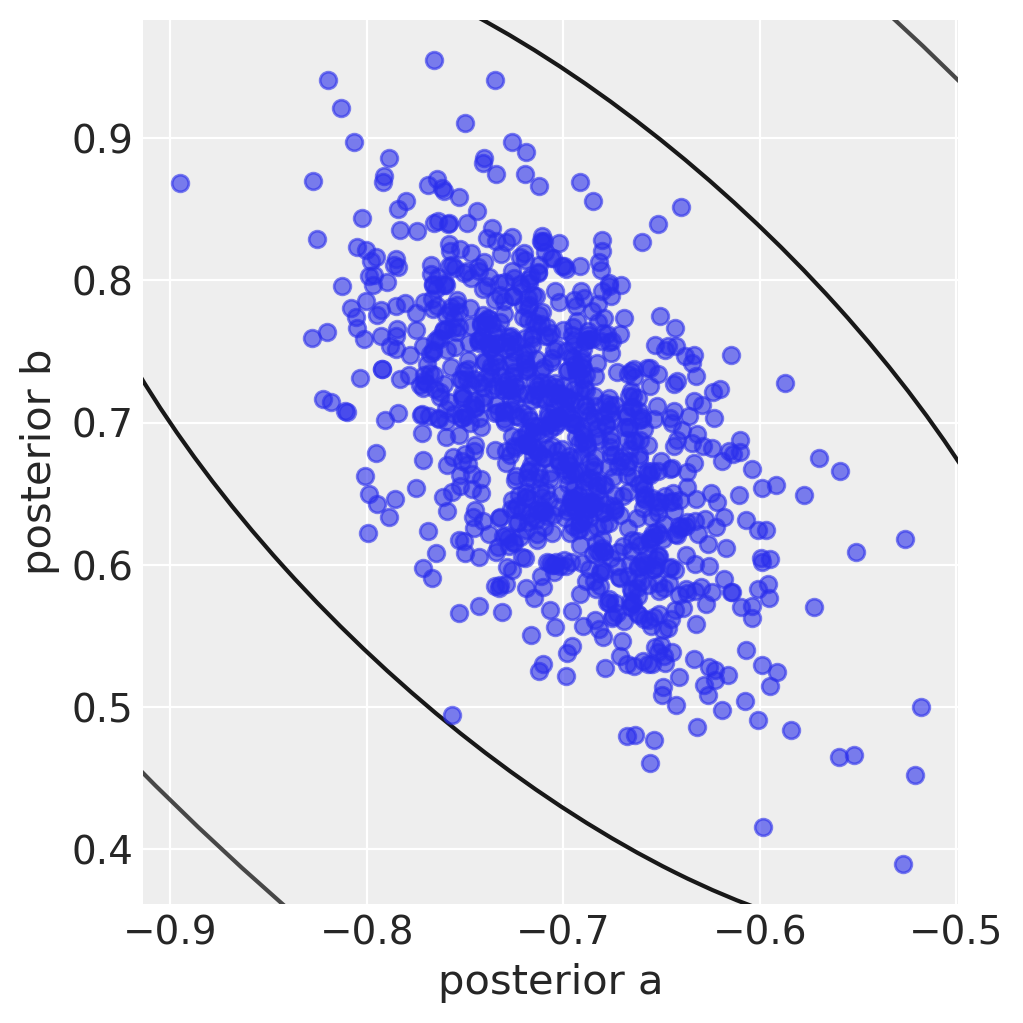

In [45]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
_ = Gauss2d(mu=Mu_est, cov=np.asarray(Sigma_est), ci=[0.1, 0.3, 0.5, 0.8, 0.99], ax=ax)

# plot both and connect with lines
ax.scatter(a_post, b_post, alpha=0.6)

#ax.plot([0, .6], [0, .6], "k-", alpha=0.5)
ax.set_xlabel("posterior a")
ax.set_ylabel("posterior b")
#ax.set_xlim(0, 0.6)
#ax.set_ylim(0, 0.6)
#plt.legend(fontsize=10);

What is the meaning of a negative effect due to the district? Below we plot the average contraception rate predicted through our model, in each district and separated by urban indicator. We can see that the increase in contraception is almost always present in more urbanized areas, but there isn't a clear pattern, such that the jump is always large when rural areas have low contraception rate.

In [108]:
with m_14h1:
    C_pred=pm.sample_posterior_predictive(trace_14h1, var_names=["C"], random_seed=RANDOM_SEED)

Sampling: [C]


In [109]:
C_pred

Inference data with groups:
	> posterior_predictive
	> observed_data

In [117]:
C_pred['posterior_predictive']['C'].mean(['chain','draw'])

<xarray.DataArray 'C' (C_dim_2: 1934)>
array([0.38075, 0.38425, 0.4065 , ..., 0.24825, 0.2385 , 0.24175])
Coordinates:
  * C_dim_2  (C_dim_2) int64 0 1 2 3 4 5 6 ... 1928 1929 1930 1931 1932 1933

In [119]:
df2 = pd.DataFrame()
df2['urban'] = df['urban']
df2['C'] = C_pred['posterior_predictive']['C'].mean(['chain','draw'])
df2['district'] = df['district']

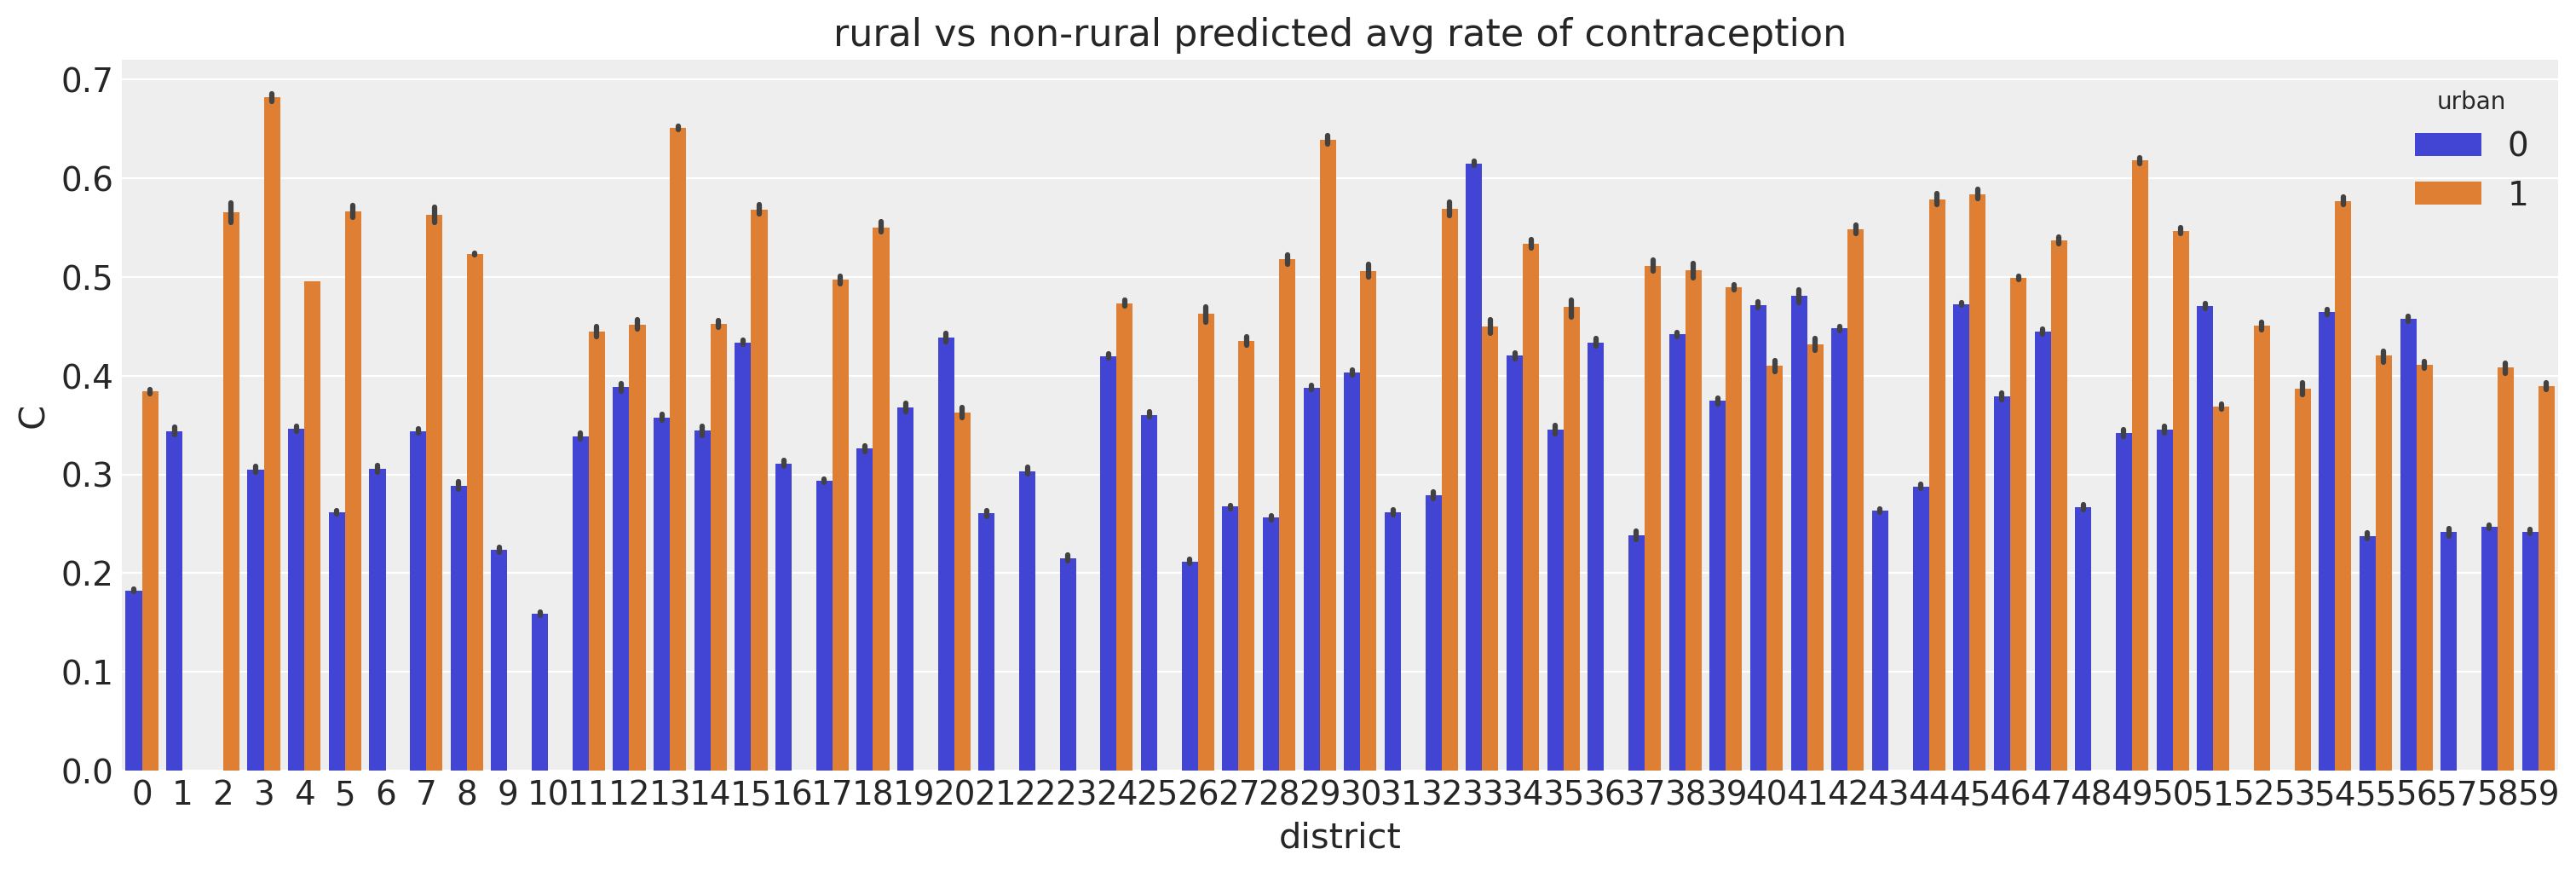

In [127]:
_, ax = plt.subplots(1, 1, figsize=(15, 5))

f = sns.barplot(data=df2, y='C', x='district', hue='urban', ax=ax)
_ = f.set_title("rural vs non-rural predicted avg rate of contraception")

The districts are not giving any information, but are just classifying into boxes the contraception events. We would need other variables to see if there is some information we can add to the model. The district alone could be seen as just randomized experiments.

Below we can see some places where age is lower than average (<0) and where contraception rate is high. So it might be that age influences directly contraception.

In [132]:
df2['age_centered'] = df['age_centered']

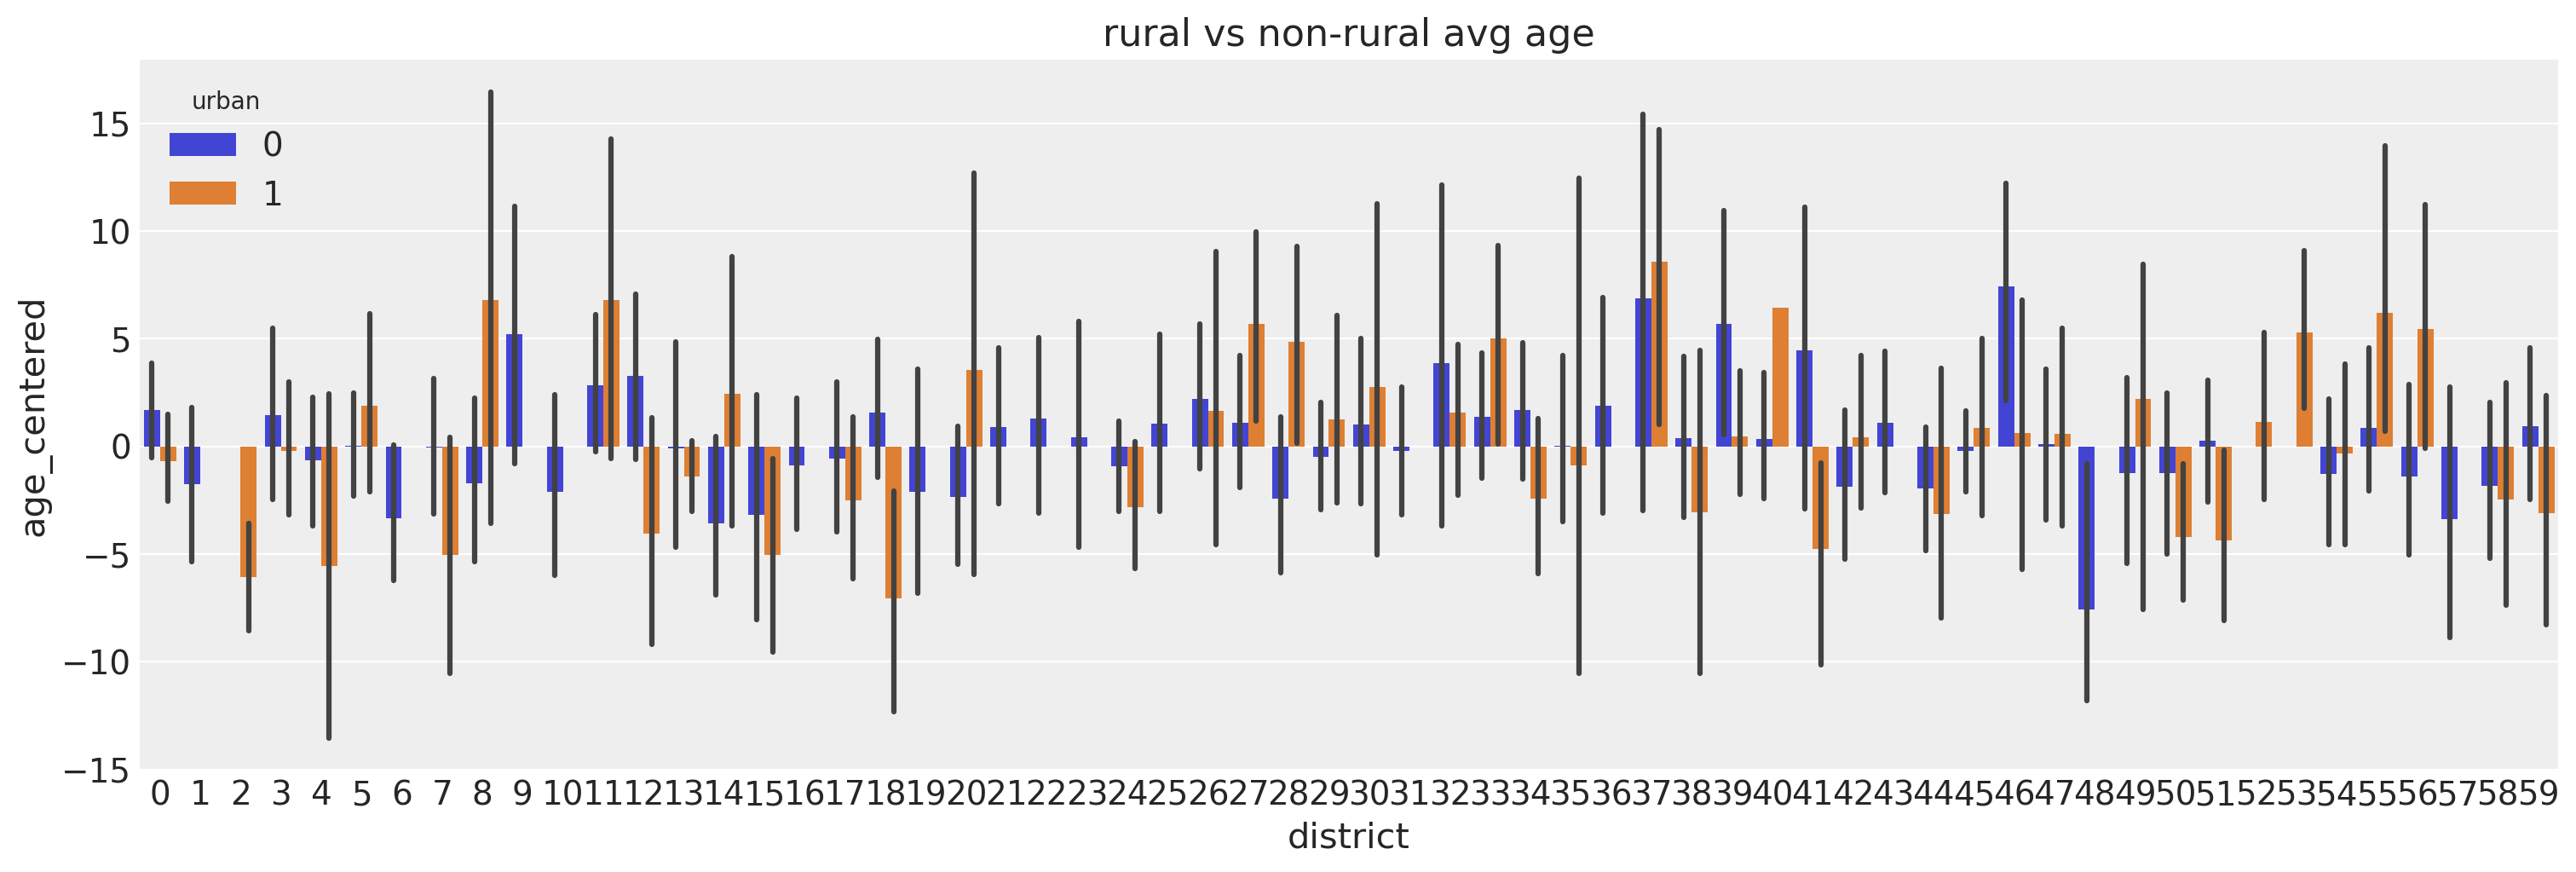

In [134]:
_, ax = plt.subplots(1, 1, figsize=(15, 5))

f = sns.barplot(data=df2, y='age_centered', x='district', hue='urban', ax=ax)
_ = f.set_title("rural vs non-rural avg age")

We can see that the nr of living children is directly influenced by the increasing age

In [135]:
df2['living_children'] = df['living_children']

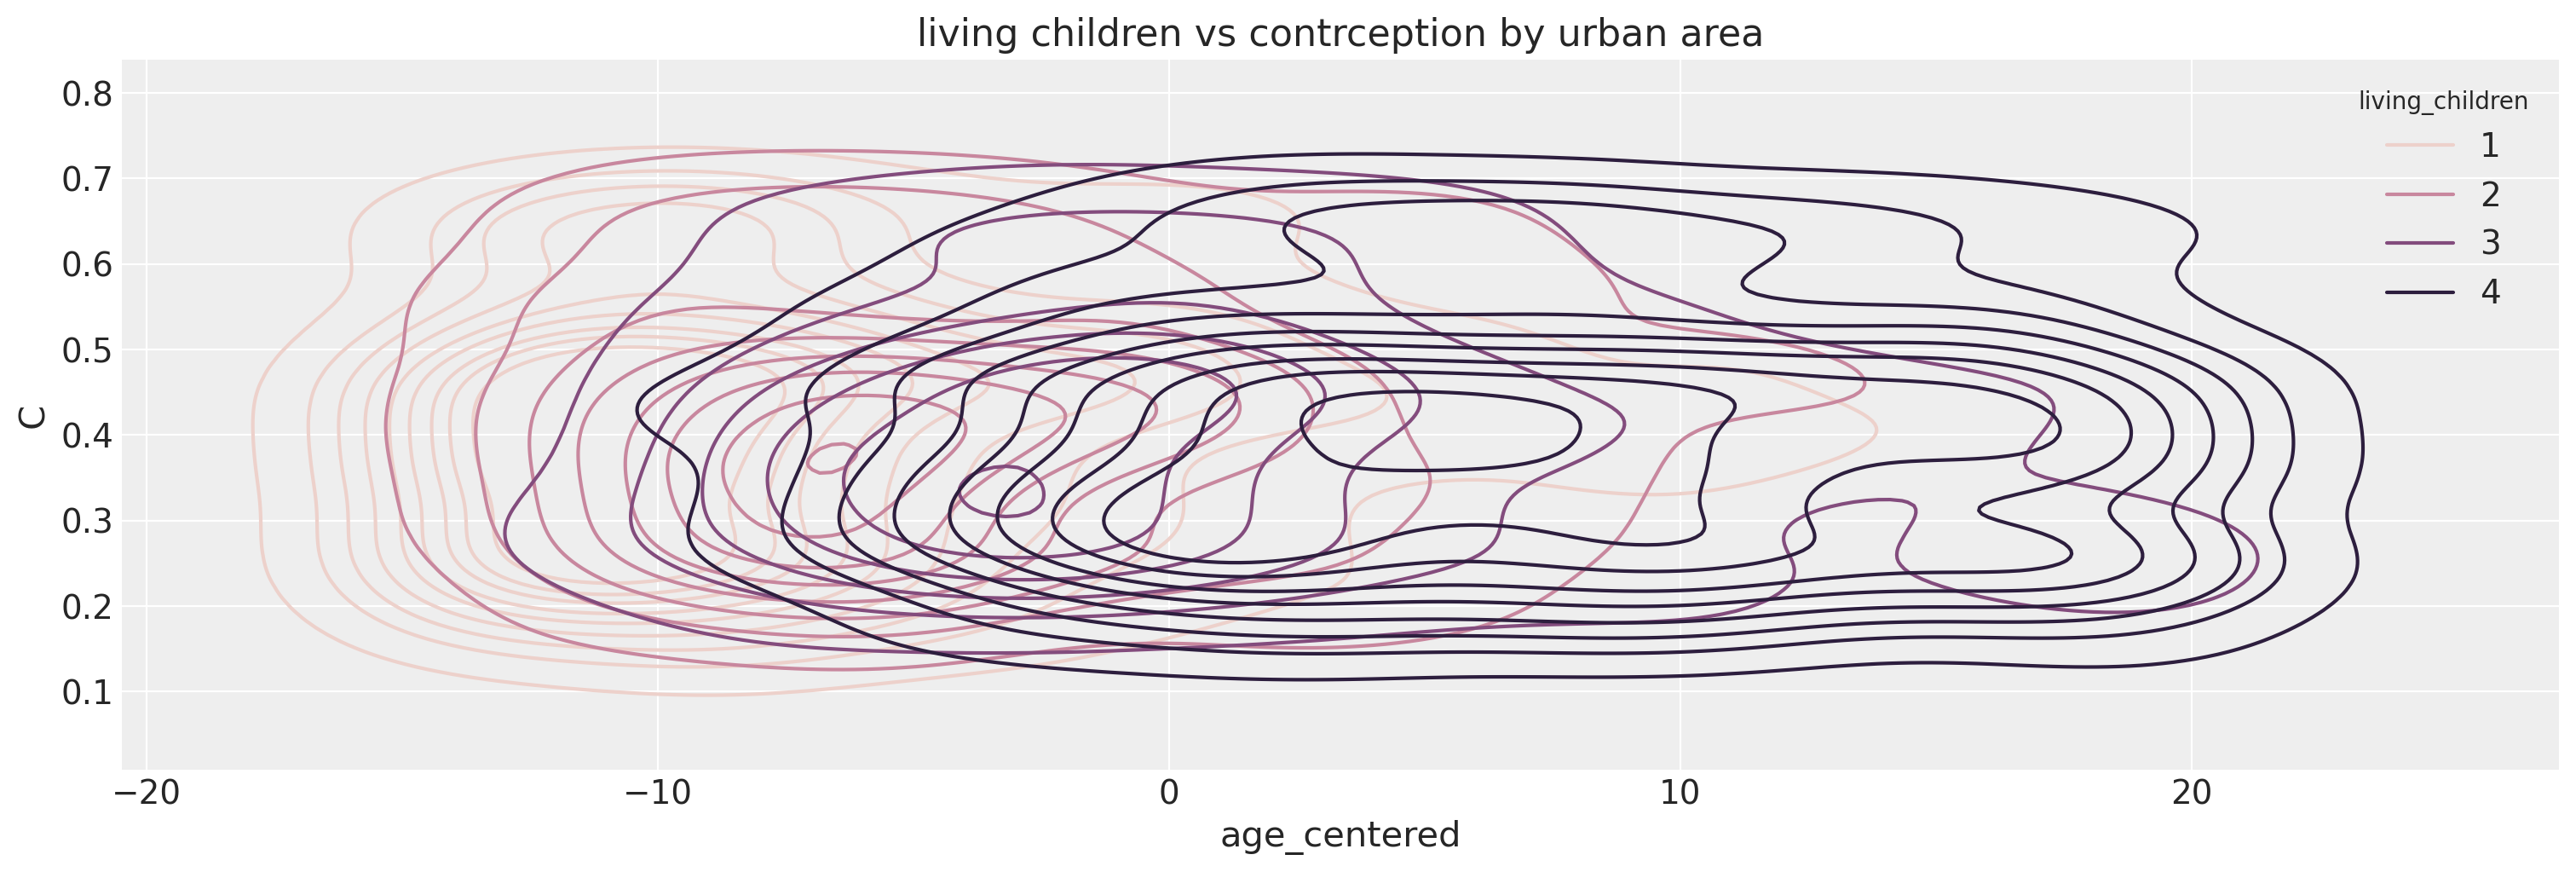

In [152]:
_, ax = plt.subplots(1, 1, figsize=(15, 5))

f = sns.kdeplot(data=df2, y='C', x='age_centered', hue='living_children',ax=ax)
_ = f.set_title("living children vs contrception by urban area")

It is not directly easy to have an intuition about patterns of influence between children and contraception, but we can see there might be different patterns of contraception across districts when we increase the number of living children.

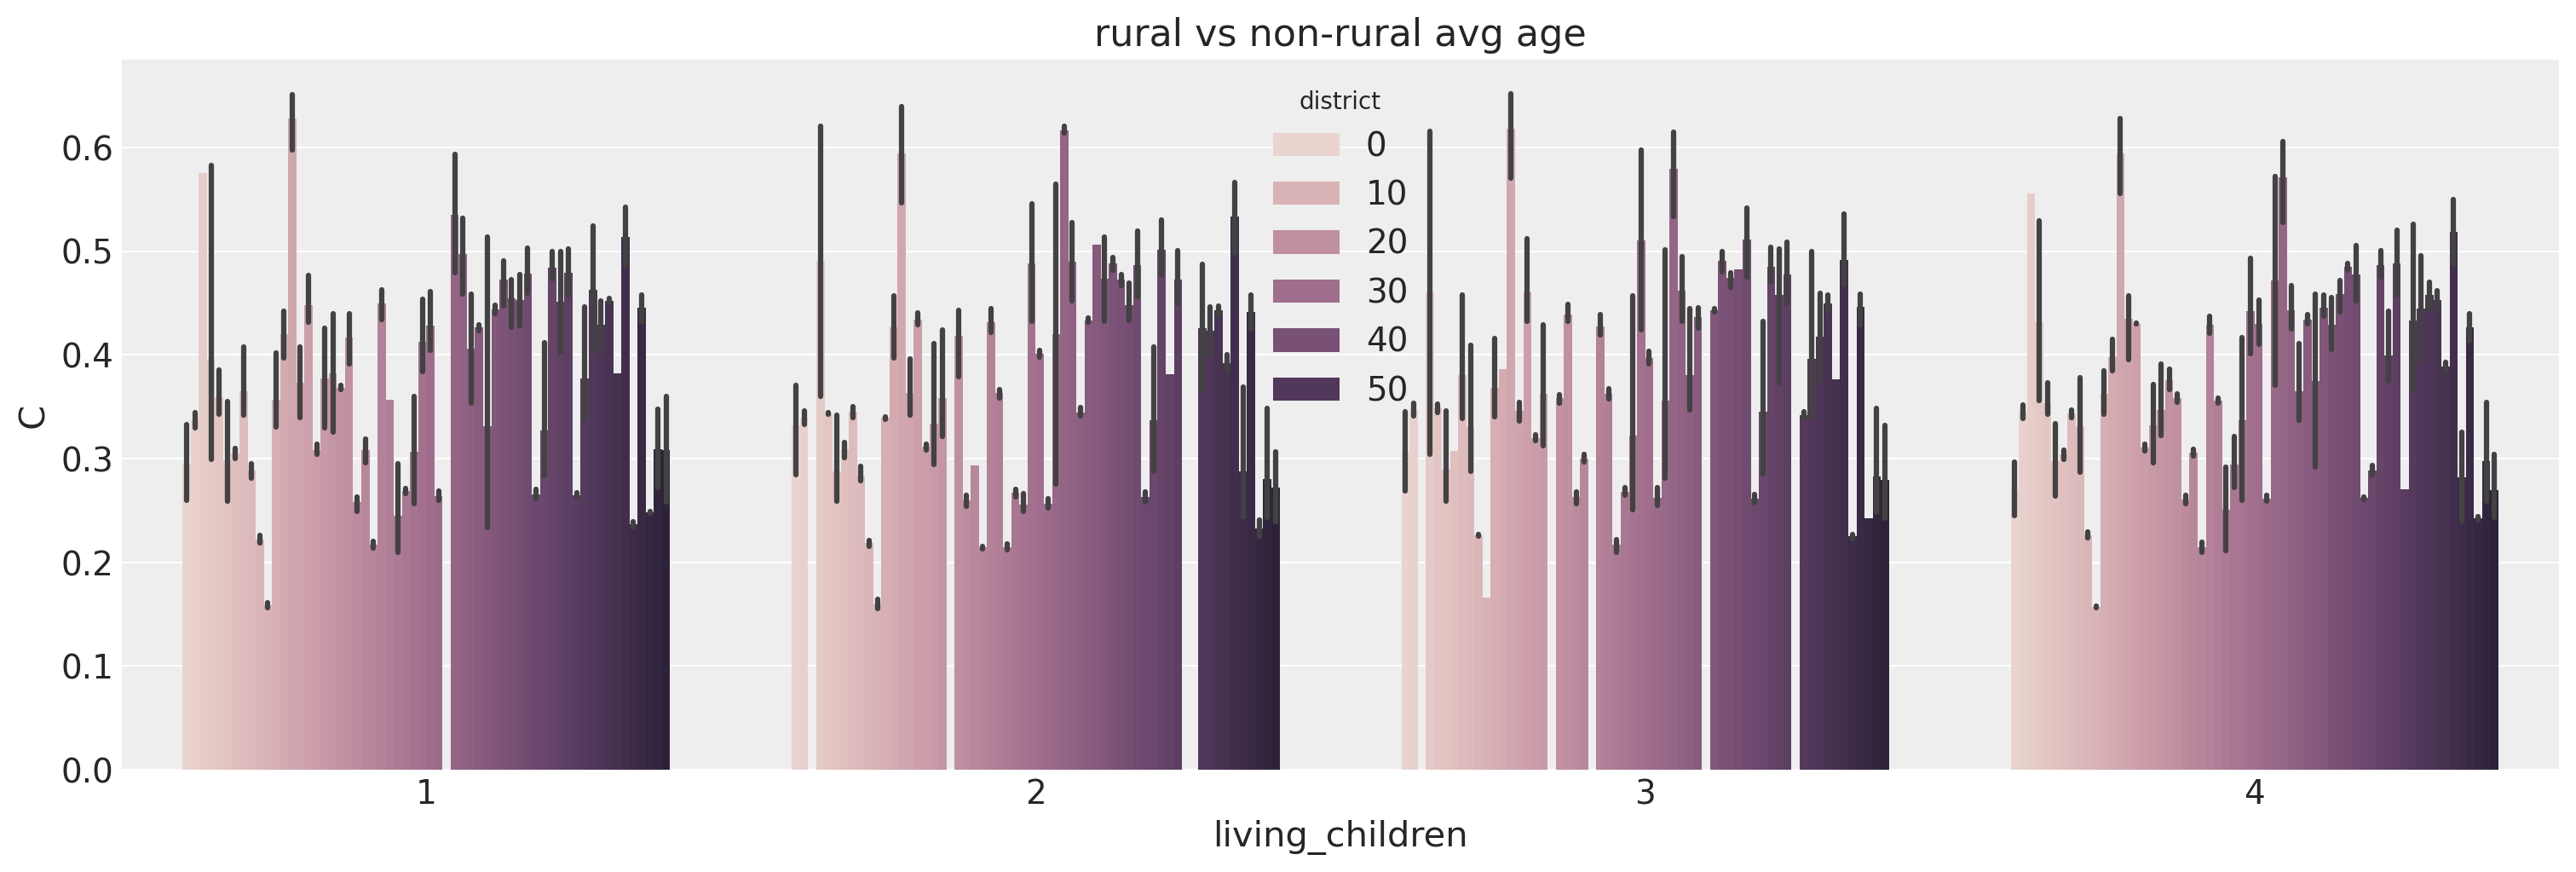

In [153]:
_, ax = plt.subplots(1, 1, figsize=(15, 5))

f = sns.barplot(data=df2, y='C', x='living_children', hue='district', ax=ax)
_ = f.set_title("rural vs non-rural avg age")

By averaging it seems though the C valuesare constant, but with a bayesian model we might capture some patterns maybe present in the behaviour above

In [156]:
df2.groupby('living_children').mean()[ ['C','age_centered'] ]

C  age_centered
living_children                        
1                0.395069     -7.644528
2                0.403980     -3.860393
3                0.398041      0.240064
4                0.383396      7.209867

## Exercise 14H2

Now consider the predictor variables `age_centered` and `living_children`, also contained in the `bangladesh` data. Suppose that age influences contraceptive use (changing attitudes) and number of children (older people have had more time to have kids). Number of children may also directly influence contraceptive use. Draw a DAG that reflects these hypothetical relationships. Then build models needed to evaluate the DAG. You will need at least two models. Retain `district` and `urban`, as in 14H1. What do you conclude about the causal influence of age and children?

<Axes: xlabel='district', ylabel='age_centered'>

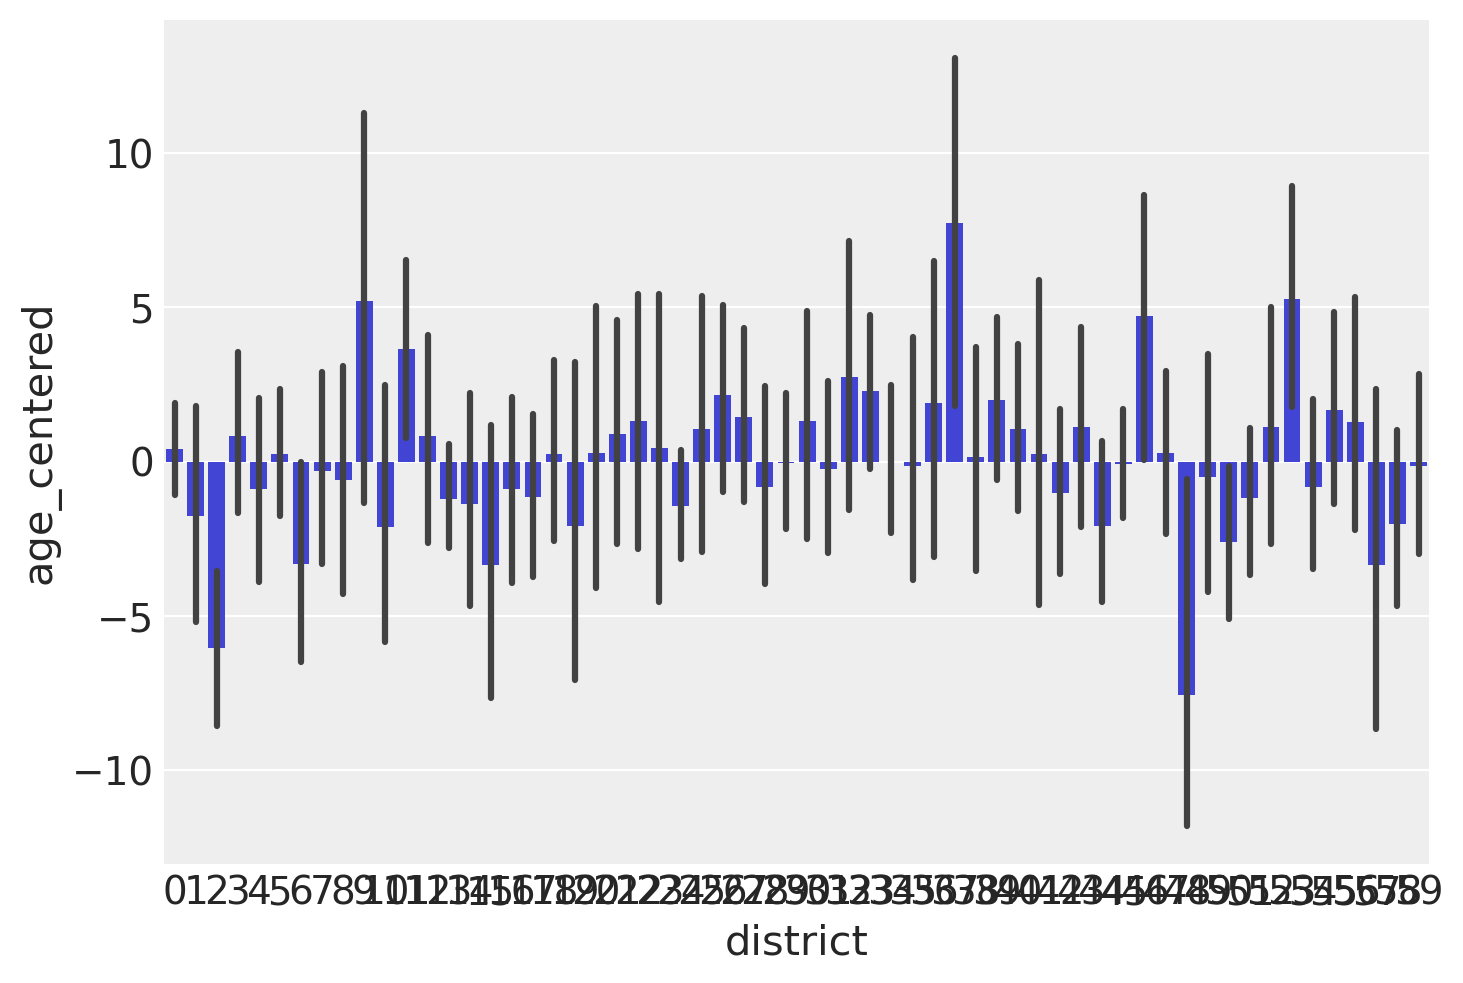

In [131]:
sns.barplot(data=df, x='district',y='age_centered')

Text(0, 0.5, 'posterior b')

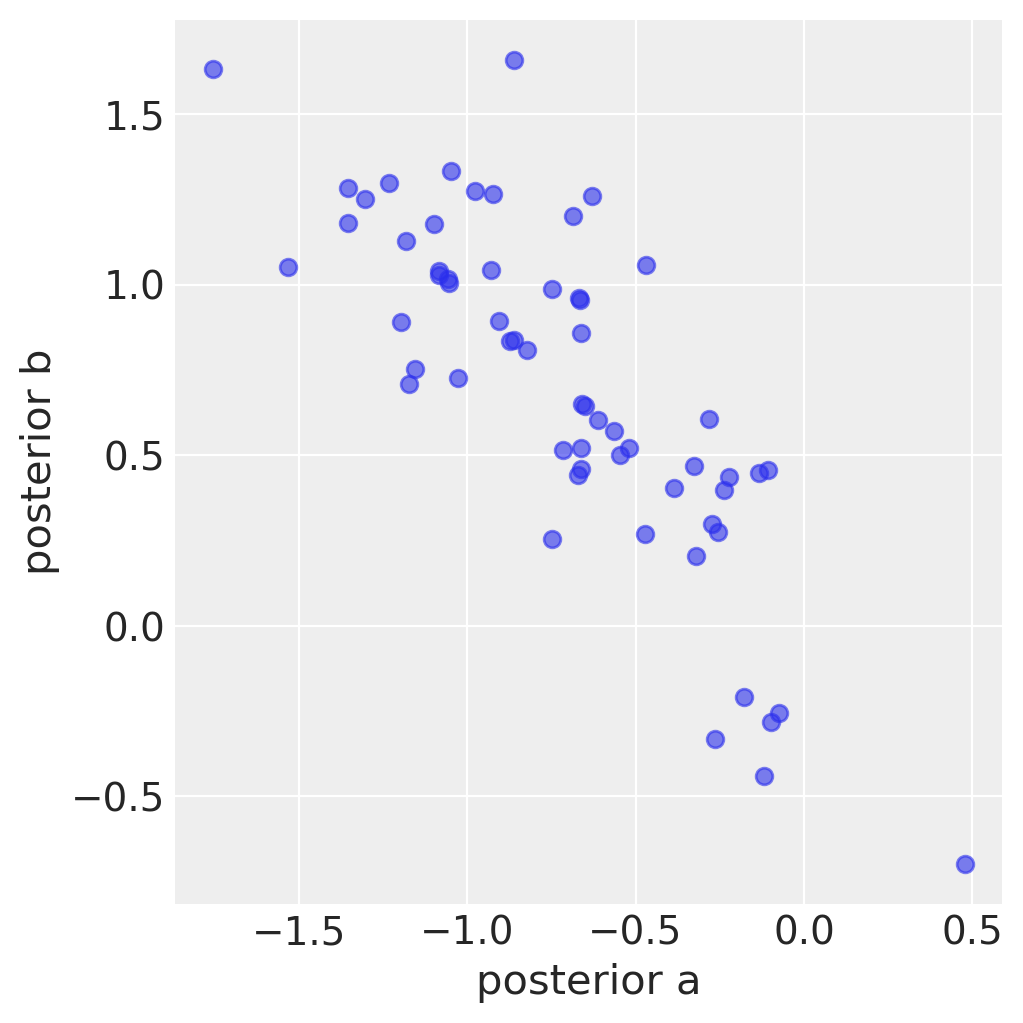

In [76]:
# store pareto-k values for plot:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
#_ = Gauss2d(mu=Mu_est, cov=np.asarray(Sigma_est), ci=[0.1, 0.3, 0.5, 0.8, 0.99], ax=ax)

# plot both and connect with lines
ax.scatter(ab_post[:,0], ab_post[:,1], alpha=0.6)

#ax.plot([0, .6], [0, .6], "k-", alpha=0.5)
ax.set_xlabel("intercept")
ax.set_ylabel("slope")
#ax.set_xlim(0, 0.6)
#ax.set_ylim(0, 0.6)
#plt.legend(fontsize=10);

In [66]:
seab

ValueError: operands could not be broadcast together with shapes (1000,) (1934,) 

In [9]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Dec 15 2023

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.18.1

pymc      : 4.3.0
aesara    : 2.8.7
numpy     : 1.22.4
scipy     : 1.7.3
arviz     : 0.13.0
pandas    : 2.1.4
matplotlib: 3.8.2

Watermark: 2.4.3

